In [1]:
import simtk
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
from gst.gst import grestIntegrator, SimulatedSoluteTempering
import numpy as np

In [152]:
def setup_system(filename):
  """Creates a 'system' object given a pdb filename"""
  pdb = PDBFile(filename)
  forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
  system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds) 
  #barostat = MonteCarloBarostat(1*bar, 310*kelvin)
  #system.addForce(barostat)
  set_dihedral_force_group(system)
  print('Created system')
  return system, pdb

def setup_system_vacuum(filename):
  """Creates a 'system' object given a pdb filename"""
  pdb = PDBFile(filename)
  forcefield = ForceField('amber99sb.xml', 'tip3p.xml')
  system = forcefield.createSystem(pdb.topology, constraints=AllBonds, hydrogenMass=3*amu)
  #barostat = MonteCarloBarostat(1*bar, 310*kelvin)
  #system.addForce(barostat)
  set_dihedral_force_group(system)
  print('Created system')
  return system, pdb

def setup_system_implicit(filename):
  """Creates a 'system' object given a pdb filename"""
  pdb = PDBFile(filename)
  forcefield = app.ForceField('amber99sbildn.xml', 'amber99_obc.xml')
  system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.CutoffNonPeriodic, constraints=HBonds,)
  #barostat = MonteCarloBarostat(1*bar, 310*kelvin)
  #system.addForce(barostat)
  set_dihedral_force_group(system)
  print('Created system')
  return system, pdb


def set_dihedral_force_group(system, g=2):
  """Sets the dihedral forcegroup to a number other than 0,
  which will be used by serial tempering"""
  print('Scanning forces:')
  for f in system.getForces():
    if isinstance(f, simtk.openmm.openmm.PeriodicTorsionForce):
      print('Found the torsions - setting group to 2')
      f.setForceGroup(2)
    print(f.getForceGroup(), f.__class__)

def setup_simulation(system, pdb, integrator):
  platform = Platform.getPlatformByName('CPU')
  prop = {'CPUPrecision':'single'}
  simulation = Simulation(pdb.topology, system, integrator, platform)
  simulation.context.setPositions(pdb.positions)
  #simulation.context.setPeriodicBoxVectors(Vec3(2.846979248047194, 0.0, 0.0), 
  #                                         Vec3(-1.423489624023597, 2.8460968399199644, 0.0), 
  #                                         Vec3(0.0, 0.0, 2.767338609857905))
  simulation.minimizeEnergy()
  simulation.context.setVelocitiesToTemperature(310*kelvin)
  print('Created simulation')
  return simulation

In [153]:
filename = './villin/input.pdb'

In [177]:
pdb = PDBFile(filename)
#got to remove the waters and ions because we are running implicit:
modeller = Modeller(pdb.topology, pdb.positions)
to_delete = list()
for atom in pdb.topology.atoms():
    if atom.residue.name in ['HOH', 'Cl']:
        to_delete.append(atom)
modeller.delete(to_delete)

forcefield = app.ForceField('amber99sbildn.xml', 'amber99_obc.xml')
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.CutoffNonPeriodic, constraints=HBonds,)
integrator = grestIntegrator(650*kelvin, 1/picosecond, 0.002*picoseconds, 2, 1)

simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
    

In [178]:
simulation.minimizeEnergy(50)
simulation.context.setVelocitiesToTemperature(650*kelvin)

In [179]:
simulation.reporters.append(DCDReporter('./villin/villin_equil.dcd', 500))
simulation.reporters.append(StateDataReporter(stdout, 500, step=True,
        potentialEnergy=True, density=True, speed=True))

In [180]:
PDBFile.writeFile(modeller.topology, modeller.positions, open('./villin/villin-implicit.pdb', 'w'))

In [181]:
simulation.step(500000)
PDBFile.writeFile(modeller.topology, modeller.positions, open('./villin/villin-implicit.pdb', 'w'))

#"Step","Potential Energy (kJ/mole)","Density (g/mL)","Speed (ns/day)"
500,-1821.63720703125,0.07717668471337512,0
1000,-952.7626342773438,0.07717668471337512,98.6
1500,-1227.291015625,0.07717668471337512,99.4
2000,-1026.934814453125,0.07717668471337512,100
2500,-1001.3761596679688,0.07717668471337512,99.9
3000,-1060.581298828125,0.07717668471337512,99.3
3500,-1137.2821044921875,0.07717668471337512,99.6
4000,-971.0323486328125,0.07717668471337512,100
4500,-905.9235229492188,0.07717668471337512,100
5000,-810.9002685546875,0.07717668471337512,101
5500,-1031.9404296875,0.07717668471337512,101
6000,-919.177734375,0.07717668471337512,100
6500,-837.6310424804688,0.07717668471337512,101
7000,-860.3948974609375,0.07717668471337512,101
7500,-808.365966796875,0.07717668471337512,101
8000,-1011.5499267578125,0.07717668471337512,101
8500,-1072.09765625,0.07717668471337512,101
9000,-790.2298583984375,0.07717668471337512,101
9500,-862.1876831054688,0.07717668471337512,101
10000,-964.538818359375,0.0

83500,-759.87890625,0.07717668471337512,92.7
84000,-1013.2782592773438,0.07717668471337512,92.6
84500,-818.6921997070312,0.07717668471337512,92.6
85000,-1001.1800537109375,0.07717668471337512,92.6
85500,-761.9365844726562,0.07717668471337512,92.6
86000,-565.30029296875,0.07717668471337512,92.5
86500,-844.9569091796875,0.07717668471337512,92.5
87000,-911.9533081054688,0.07717668471337512,92.5
87500,-646.60546875,0.07717668471337512,92.5
88000,-804.2334594726562,0.07717668471337512,92.6
88500,-717.427734375,0.07717668471337512,92.6
89000,-535.1609497070312,0.07717668471337512,92.6
89500,-625.3294677734375,0.07717668471337512,92.6
90000,-649.3297119140625,0.07717668471337512,92.6
90500,-694.1302490234375,0.07717668471337512,92.5
91000,-687.9017333984375,0.07717668471337512,92.5
91500,-413.7376708984375,0.07717668471337512,92.4
92000,-689.8386840820312,0.07717668471337512,92.2
92500,-500.1827392578125,0.07717668471337512,92
93000,-737.5519409179688,0.07717668471337512,91.9
93500,-711.40209

165500,-673.6158447265625,0.07717668471337512,90.2
166000,-943.6129150390625,0.07717668471337512,90.2
166500,-584.0897827148438,0.07717668471337512,90.2
167000,-574.3983154296875,0.07717668471337512,90.1
167500,-353.7886047363281,0.07717668471337512,90.1
168000,-690.3282470703125,0.07717668471337512,90.1
168500,-922.594482421875,0.07717668471337512,90.1
169000,-705.4693603515625,0.07717668471337512,89.9
169500,-597.574951171875,0.07717668471337512,89.9
170000,-561.74072265625,0.07717668471337512,89.8
170500,-521.5302734375,0.07717668471337512,89.6
171000,-580.5067749023438,0.07717668471337512,89.3
171500,-602.2017211914062,0.07717668471337512,89.3
172000,-467.2254638671875,0.07717668471337512,89.4
172500,-629.2540283203125,0.07717668471337512,89.4
173000,-734.72509765625,0.07717668471337512,89.5
173500,-556.1981201171875,0.07717668471337512,89.5
174000,-477.10479736328125,0.07717668471337512,89.5
174500,-421.583251953125,0.07717668471337512,89.5
175000,-445.7667236328125,0.077176684713

247000,-561.7679443359375,0.07717668471337512,88.8
247500,-514.7732543945312,0.07717668471337512,88.8
248000,-638.305419921875,0.07717668471337512,88.8
248500,-842.5570678710938,0.07717668471337512,88.8
249000,-679.37841796875,0.07717668471337512,88.8
249500,-587.4144287109375,0.07717668471337512,88.8
250000,-691.6884155273438,0.07717668471337512,88.8
250500,-749.3015747070312,0.07717668471337512,88.7
251000,-659.22998046875,0.07717668471337512,88.7
251500,-930.8385009765625,0.07717668471337512,88.7
252000,-832.0184326171875,0.07717668471337512,88.6
252500,-536.9398193359375,0.07717668471337512,88.6
253000,-520.4819946289062,0.07717668471337512,88.6
253500,-742.857666015625,0.07717668471337512,88.6
254000,-713.269287109375,0.07717668471337512,88.6
254500,-273.97613525390625,0.07717668471337512,88.6
255000,-526.3754272460938,0.07717668471337512,88.6
255500,-681.611328125,0.07717668471337512,88.6
256000,-801.2471313476562,0.07717668471337512,88.6
256500,-710.5323486328125,0.0771766847133

328500,-918.17041015625,0.07717668471337512,87.5
329000,-359.91448974609375,0.07717668471337512,87.5
329500,-635.1063232421875,0.07717668471337512,87.4
330000,-724.3350219726562,0.07717668471337512,87.4
330500,-590.1157836914062,0.07717668471337512,87.4
331000,-674.1748046875,0.07717668471337512,87.4
331500,-468.55206298828125,0.07717668471337512,87.4
332000,-624.118896484375,0.07717668471337512,87.4
332500,-768.49072265625,0.07717668471337512,87.4
333000,-674.2040405273438,0.07717668471337512,87.4
333500,-477.65771484375,0.07717668471337512,87.4
334000,-810.9385375976562,0.07717668471337512,87.4
334500,-793.416015625,0.07717668471337512,87.4
335000,-702.4049072265625,0.07717668471337512,87.4
335500,-526.744873046875,0.07717668471337512,87.4
336000,-490.41778564453125,0.07717668471337512,87.4
336500,-332.44287109375,0.07717668471337512,87.4
337000,-373.7930908203125,0.07717668471337512,87.3
337500,-469.38525390625,0.07717668471337512,87.3
338000,-358.8748779296875,0.07717668471337512,8

KeyboardInterrupt: 

In [184]:
PDBFile.writeFile(modeller.topology, modeller.positions, open('./villin/villin-implicit.pdb', 'w'))

In [ ]:
filename_implicit = './villin-implicit.pdb'

In [ ]:
system, pdb = setup_system_implicit(filename_implicit)
integrator = grestIntegrator(310*kelvin, 1/picosecond, 0.002*picoseconds, 2, 1)
simulation = setup_simulation(system, pdb, integrator)

#Instantiate reporters
simulation.reporters.append(DCDReporter(output_directory+'villin_standardmd_traj_local.dcd', dcdstride))
simulation.reporters.append(StateDataReporter(stdout, 50000, step=True, totalSteps=number_steps,remainingTime=True,
                                              potentialEnergy=True, density=True, speed=True))
simulation.step(number_steps)

# Running actual GST:

In [30]:
from tqdm import tqdm_notebook
#system, pdb = setup_system('./dialanine/alanine-dipeptide-explicit.pdb')
system, pdb = setup_system_implicit('./dialanine/alanine-dipeptide-implicit.pdb')
integrator = grestIntegrator(310*kelvin, 1/picosecond, 0.002*picoseconds, 2, 1)
simulation = setup_simulation(system, pdb, integrator)


##The simulated tempering object:
st = SimulatedSoluteTempering(simulation,
                              forceGroup=2,
                              cutoff=1e-8,
                              numTemperatures=12,
                              tempChangeInterval=50,
                              minTemperature=310*kelvin,
                              maxTemperature=1100*kelvin,
                              reportInterval=50,
                              #reportFile=stdout,
                              reportFile='./dialanine/diala_gst_temp_local.dat',
                             )
                              #reportFile='./dialanine/diala_gst_temp2.dat')


for _ in tqdm_notebook(range(20000)):
   simulation.step(500)
   print(st._weightUpdateFactor, st.currentTemperature)
   if st._weightUpdateFactor<st.cutoff:
        break

Scanning forces:
0 <class 'simtk.openmm.openmm.HarmonicBondForce'>
0 <class 'simtk.openmm.openmm.HarmonicAngleForce'>
Found the torsions - setting group to 2
2 <class 'simtk.openmm.openmm.PeriodicTorsionForce'>
0 <class 'simtk.openmm.openmm.NonbondedForce'>
0 <class 'simtk.openmm.openmm.GBSAOBCForce'>
0 <class 'simtk.openmm.openmm.CMMotionRemover'>
Created system
Created simulation
1e-08


1.0 1
1.0 4
1.0 2
1.0 6
1.0 0
1.0 1
1.0 1
1.0 0
1.0 1
1.0 3
1.0 3
1.0 8
1.0 3
1.0 3
1.0 9
1.0 0
1.0 1
1.0 10
1.0 11
1.0 10
1.0 4
1.0 5
1.0 9
1.0 9
1.0 10
1.0 5
1.0 1
1.0 11
1.0 9
1.0 4
1.0 11
1.0 6
1.0 5
0.5 11
0.5 8
0.5 0
0.5 2
0.5 11
0.5 2
0.5 3
0.5 7
0.5 0
0.5 0
0.5 11
0.5 9
0.5 1
0.5 2
0.5 1
0.5 10
0.5 4
0.5 8
0.5 2
0.5 11
0.5 4
0.5 0
0.5 4
0.5 8
0.5 2
0.5 1
0.5 6
0.5 10
0.5 4
0.5 8
0.5 11
0.5 9
0.5 7
0.25 8
0.25 8
0.25 9
0.25 5
0.25 6
0.25 11
0.25 1
0.25 8
0.25 7
0.25 2
0.25 9
0.25 10
0.25 8
0.25 3
0.25 9
0.25 11
0.25 1
0.25 0
0.25 6
0.25 4
0.25 5
0.25 7
0.25 1
0.25 9
0.25 7
0.25 7
0.25 0
0.25 0
0.25 0
0.25 1
0.125 4
0.125 10
0.125 6
0.125 10
0.125 6
0.125 11
0.125 11
0.125 6
0.125 9
0.125 10
0.125 0
0.125 1
0.125 7
0.125 1
0.125 4
0.125 7
0.125 3
0.125 5
0.125 1
0.125 4
0.125 1
0.125 0
0.125 5
0.125 7
0.125 5
0.125 9
0.125 1
0.125 6
0.125 8
0.125 0
0.125 4
0.125 2
0.0625 2
0.0625 5
0.0625 6
0.0625 5
0.0625 4
0.0625 10
0.0625 4
0.0625 2
0.0625 10
0.0625 9
0.0625 6
0.0625 2
0.0625 

6.103515625e-05 8
6.103515625e-05 7
6.103515625e-05 4
6.103515625e-05 10
6.103515625e-05 6
6.103515625e-05 9
6.103515625e-05 10
6.103515625e-05 6
6.103515625e-05 5
6.103515625e-05 10
6.103515625e-05 8
6.103515625e-05 11
6.103515625e-05 9
6.103515625e-05 11
6.103515625e-05 3
6.103515625e-05 8
6.103515625e-05 6
6.103515625e-05 5
6.103515625e-05 1
6.103515625e-05 11
6.103515625e-05 2
6.103515625e-05 3
6.103515625e-05 3
6.103515625e-05 4
6.103515625e-05 1
6.103515625e-05 3
6.103515625e-05 10
6.103515625e-05 10
6.103515625e-05 6
6.103515625e-05 9
6.103515625e-05 10
6.103515625e-05 9
6.103515625e-05 2
6.103515625e-05 5
6.103515625e-05 8
6.103515625e-05 2
6.103515625e-05 11
6.103515625e-05 3
6.103515625e-05 7
6.103515625e-05 6
6.103515625e-05 7
6.103515625e-05 7
6.103515625e-05 5
6.103515625e-05 0
6.103515625e-05 8
6.103515625e-05 11
6.103515625e-05 2
6.103515625e-05 5
6.103515625e-05 3
6.103515625e-05 10
6.103515625e-05 10
6.103515625e-05 2
3.0517578125e-05 4
3.0517578125e-05 4
3.0517578125e

2.384185791015625e-07 4
2.384185791015625e-07 4
2.384185791015625e-07 8
2.384185791015625e-07 5
2.384185791015625e-07 0
2.384185791015625e-07 6
2.384185791015625e-07 2
2.384185791015625e-07 7
2.384185791015625e-07 5
2.384185791015625e-07 5
2.384185791015625e-07 3
2.384185791015625e-07 6
2.384185791015625e-07 1
2.384185791015625e-07 11
2.384185791015625e-07 6
2.384185791015625e-07 4
2.384185791015625e-07 1
2.384185791015625e-07 11
2.384185791015625e-07 2
2.384185791015625e-07 8
2.384185791015625e-07 2
2.384185791015625e-07 3
2.384185791015625e-07 7
2.384185791015625e-07 2
2.384185791015625e-07 1
2.384185791015625e-07 11
2.384185791015625e-07 3
2.384185791015625e-07 1
2.384185791015625e-07 7
2.384185791015625e-07 8
2.384185791015625e-07 2
2.384185791015625e-07 9
2.384185791015625e-07 8
2.384185791015625e-07 0
2.384185791015625e-07 2
2.384185791015625e-07 6
2.384185791015625e-07 8
2.384185791015625e-07 10
1.1920928955078125e-07 0
1.1920928955078125e-07 5
1.1920928955078125e-07 3
1.1920928

In [31]:
#Now, remove the simulated tempering (which is just a reporter)
#and add the DCD reporter, and the state reporter.
simulation.reporters.pop(0)
import numpy as np
weights_store = np.array(st.weights).copy()
#    def set_weights(self, newWeights):
#        self._weights = newWeights


In [34]:
weights_store

array([ 0.        ,  4.85539995,  8.78359953, 11.88068269, 14.13977273,
       16.38421735, 18.15856348, 19.61692895, 20.78915212, 22.04781963,
       22.92241831, 23.73603518])

In [35]:
##The simulated tempering object:
st = SimulatedSoluteTempering(simulation,
                              forceGroup=2,
                              cutoff=1e-8,
                              numTemperatures=12,
                              tempChangeInterval=50,
                              minTemperature=310*kelvin,
                              maxTemperature=1100*kelvin,
                              reportInterval=500,
                              reportFile='./dialanine/diala_gst_temp_local2.dat',
                             )



1e-08


In [36]:
st._weights = list(weights_store)
st._updateWeights = False


simulation.reporters.append(DCDReporter('./dialanine/diala_gst_traj_local.dcd', 500))
simulation.reporters.append(StateDataReporter(stdout, 500, step=True,
        potentialEnergy=True, density=True, speed=True))

In [37]:
one_ns = int(5e5)
number_ns = 10
number_steps = number_ns*one_ns
number_steps

5000000

In [38]:
simulation.step(number_steps)

#"Step","Potential Energy (kJ/mole)","Density (g/mL)","Speed (ns/day)"
618000,-51.587121604969525,0.010676642612682098,0
618500,-50.90578472477344,0.010676642612682098,316
619000,-75.46695695652983,0.010676642612682098,293
619500,-3.9591219145590912,0.010676642612682098,295
620000,-51.632541465419706,0.010676642612682098,297
620500,-56.9129707064734,0.010676642612682098,301
621000,-81.1091042417641,0.010676642612682098,303
621500,-74.07143899406535,0.010676642612682098,300
622000,-85.28286552543332,0.010676642612682098,296
622500,-38.27373530037815,0.010676642612682098,295
623000,-17.16189824874607,0.010676642612682098,298
623500,-21.793526434083986,0.010676642612682098,297
624000,19.23890349997572,0.010676642612682098,297
624500,-73.31913261669189,0.010676642612682098,298
625000,-57.183677204831554,0.010676642612682098,300
625500,-20.158703661189975,0.010676642612682098,302
626000,-79.46137884783272,0.010676642612682098,304
626500,-61.594894183205184,0.010676642612682098,305
627000,-4

698000,-59.4399165790947,0.010676642612682098,322
698500,-13.717023590893405,0.010676642612682098,322
699000,-97.45388527517554,0.010676642612682098,322
699500,-50.826631858189614,0.010676642612682098,322
700000,-28.541868666187128,0.010676642612682098,322
700500,-73.97570381636586,0.010676642612682098,322
701000,-71.96321618970224,0.010676642612682098,323
701500,-67.29710048013834,0.010676642612682098,323
702000,-108.5175795009758,0.010676642612682098,322
702500,0.9756464908741691,0.010676642612682098,322
703000,-9.22015120684324,0.010676642612682098,323
703500,-67.28423495372206,0.010676642612682098,323
704000,-44.47222632725925,0.010676642612682098,323
704500,-39.24895833400694,0.010676642612682098,323
705000,-67.49063656339247,0.010676642612682098,323
705500,-48.61585530042842,0.010676642612682098,323
706000,-60.754383934176076,0.010676642612682098,323
706500,-53.48305424549676,0.010676642612682098,323
707000,-64.00857480660693,0.010676642612682098,323
707500,-72.95181064697795,0.0

778500,-112.43911319855806,0.010676642612682098,332
779000,-112.96664898562442,0.010676642612682098,332
779500,-96.9528342032589,0.010676642612682098,332
780000,-79.94166248528344,0.010676642612682098,333
780500,-84.63895407330816,0.010676642612682098,333
781000,-81.95585326121883,0.010676642612682098,334
781500,-69.81604846906374,0.010676642612682098,334
782000,-93.19906395711905,0.010676642612682098,333
782500,-92.5370657143419,0.010676642612682098,333
783000,-85.44483600194825,0.010676642612682098,333
783500,-105.84143419142963,0.010676642612682098,333
784000,-49.43713066106031,0.010676642612682098,334
784500,-59.68378416859946,0.010676642612682098,334
785000,-31.092338516226818,0.010676642612682098,334
785500,-40.3429608868405,0.010676642612682098,335
786000,-106.68061488643991,0.010676642612682098,335
786500,-97.3438027666327,0.010676642612682098,335
787000,-59.98786816809161,0.010676642612682098,335
787500,-70.5869349736429,0.010676642612682098,335
788000,-109.20608749504666,0.01

859000,-69.9817785540979,0.010676642612682098,342
859500,-63.39612813135824,0.010676642612682098,342
860000,-60.76366252493034,0.010676642612682098,342
860500,-34.27220632877447,0.010676642612682098,342
861000,-63.15832616106323,0.010676642612682098,342
861500,-57.19116753936717,0.010676642612682098,343
862000,-28.93215660331998,0.010676642612682098,343
862500,-63.16544369719662,0.010676642612682098,343
863000,-76.79023615424097,0.010676642612682098,343
863500,-21.472714095223807,0.010676642612682098,344
864000,-23.72429819723476,0.010676642612682098,344
864500,-34.12047849613336,0.010676642612682098,344
865000,-69.14808194883045,0.010676642612682098,344
865500,-89.90765778510293,0.010676642612682098,344
866000,-58.54159496843346,0.010676642612682098,344
866500,-69.84040269327973,0.010676642612682098,343
867000,-53.82914748255695,0.010676642612682098,343
867500,-53.075765732255036,0.010676642612682098,343
868000,-45.176326185807,0.010676642612682098,343
868500,-87.86002223595854,0.0106

939500,-82.45326764835687,0.010676642612682098,350
940000,-7.083615151162576,0.010676642612682098,350
940500,-66.055938586136,0.010676642612682098,350
941000,-21.440156760595585,0.010676642612682098,350
941500,52.23216608237112,0.010676642612682098,350
942000,12.23228294986896,0.010676642612682098,350
942500,-51.40258986288444,0.010676642612682098,350
943000,-48.48232770951097,0.010676642612682098,350
943500,-98.41817660559818,0.010676642612682098,350
944000,-97.93897375290598,0.010676642612682098,350
944500,-110.23319804102253,0.010676642612682098,350
945000,-68.40436516387072,0.010676642612682098,350
945500,-82.30646346556469,0.010676642612682098,350
946000,-49.83296168593114,0.010676642612682098,350
946500,-93.92735814236326,0.010676642612682098,350
947000,-46.06190785974832,0.010676642612682098,350
947500,-68.52534666745788,0.010676642612682098,350
948000,-109.72756807298835,0.010676642612682098,349
948500,-99.28729152550568,0.010676642612682098,349
949000,-98.94734970174078,0.0106

1019500,-55.57625977573767,0.010676642612682098,353
1020000,-80.56189276646904,0.010676642612682098,353
1020500,-95.06055445259258,0.010676642612682098,353
1021000,-103.14785360680666,0.010676642612682098,353
1021500,-67.3285126015108,0.010676642612682098,353
1022000,-66.67322710399918,0.010676642612682098,353
1022500,-46.25140225272639,0.010676642612682098,353
1023000,-84.34489305941855,0.010676642612682098,353
1023500,-84.29049241410345,0.010676642612682098,353
1024000,-49.73370323350372,0.010676642612682098,353
1024500,-87.08024046421801,0.010676642612682098,353
1025000,-76.53800380077317,0.010676642612682098,353
1025500,-33.92159473380531,0.010676642612682098,353
1026000,-51.770522728777564,0.010676642612682098,353
1026500,-82.51568591040245,0.010676642612682098,354
1027000,-54.21758718036375,0.010676642612682098,354
1027500,-27.911724747489586,0.010676642612682098,354
1028000,-78.34810778478968,0.010676642612682098,353
1028500,-73.0686310375998,0.010676642612682098,354
1029000,-74

1098500,-81.11394836844573,0.010676642612682098,350
1099000,-47.9603865604044,0.010676642612682098,350
1099500,-76.78019277859227,0.010676642612682098,350
1100000,-52.75050782465499,0.010676642612682098,350
1100500,-92.78003352868738,0.010676642612682098,350
1101000,-78.70192829649798,0.010676642612682098,350
1101500,-70.38369407326992,0.010676642612682098,350
1102000,-78.70181169706665,0.010676642612682098,350
1102500,-48.411435220786075,0.010676642612682098,350
1103000,-77.98518370513835,0.010676642612682098,350
1103500,-67.33489968820491,0.010676642612682098,350
1104000,-43.01416062527335,0.010676642612682098,350
1104500,-75.37697148527812,0.010676642612682098,350
1105000,-73.78345137731819,0.010676642612682098,349
1105500,-66.97755246328762,0.010676642612682098,349
1106000,-61.43951582492981,0.010676642612682098,349
1106500,-80.75448160756265,0.010676642612682098,349
1107000,-85.69176885297576,0.010676642612682098,349
1107500,-75.70920053918879,0.010676642612682098,349
1108000,-67.

1177500,-89.82974184743043,0.010676642612682098,341
1178000,-113.64074858233916,0.010676642612682098,341
1178500,-94.56840338032158,0.010676642612682098,341
1179000,-83.14855828856756,0.010676642612682098,341
1179500,-65.29658110051102,0.010676642612682098,340
1180000,-70.94925362205078,0.010676642612682098,340
1180500,-36.038385976684026,0.010676642612682098,340
1181000,-19.254298335429695,0.010676642612682098,340
1181500,-74.56005292147087,0.010676642612682098,340
1182000,-5.070502877635647,0.010676642612682098,340
1182500,-73.86656956062154,0.010676642612682098,340
1183000,-57.4696689543309,0.010676642612682098,340
1183500,12.08276879919083,0.010676642612682098,340
1184000,-31.252416279497083,0.010676642612682098,340
1184500,0.27789586196254845,0.010676642612682098,340
1185000,-33.55681364409824,0.010676642612682098,340
1185500,-82.41865971432384,0.010676642612682098,340
1186000,-41.32669536800432,0.010676642612682098,340
1186500,-72.76992399079194,0.010676642612682098,340
1187000,-

1256500,-64.97121680207238,0.010676642612682098,336
1257000,-45.38520435678663,0.010676642612682098,336
1257500,-30.463772854886088,0.010676642612682098,336
1258000,-3.088744320352987,0.010676642612682098,336
1258500,-40.975216746904465,0.010676642612682098,336
1259000,-60.28187839212998,0.010676642612682098,336
1259500,-62.133971371047835,0.010676642612682098,336
1260000,-57.318813628607245,0.010676642612682098,336
1260500,-76.73166556880712,0.010676642612682098,336
1261000,-72.29170904946184,0.010676642612682098,336
1261500,-53.41998416257155,0.010676642612682098,336
1262000,-79.32177598118216,0.010676642612682098,336
1262500,-85.83518885486646,0.010676642612682098,336
1263000,-36.254249325223924,0.010676642612682098,336
1263500,-79.8702607800052,0.010676642612682098,336
1264000,-63.026153136066284,0.010676642612682098,336
1264500,-76.92536312340151,0.010676642612682098,336
1265000,-3.7593269923060575,0.010676642612682098,336
1265500,-28.54889163379775,0.010676642612682098,336
126600

1335500,8.293461604037702,0.010676642612682098,333
1336000,-81.48783432835538,0.010676642612682098,333
1336500,-88.88220977072154,0.010676642612682098,333
1337000,-64.21570397486414,0.010676642612682098,333
1337500,-85.8407677890973,0.010676642612682098,333
1338000,-97.78941737438947,0.010676642612682098,333
1338500,-72.73386966070927,0.010676642612682098,333
1339000,-96.5993958503212,0.010676642612682098,333
1339500,-97.66507243754491,0.010676642612682098,333
1340000,-94.13878396382586,0.010676642612682098,333
1340500,-78.70530108677465,0.010676642612682098,333
1341000,-66.34769390223079,0.010676642612682098,333
1341500,-67.2249544719698,0.010676642612682098,333
1342000,-64.47650992560304,0.010676642612682098,333
1342500,-94.25495884974816,0.010676642612682098,333
1343000,-62.80275241509827,0.010676642612682098,333
1343500,-55.05656288876321,0.010676642612682098,333
1344000,-83.3591868041078,0.010676642612682098,333
1344500,-68.24650914673734,0.010676642612682098,333
1345000,-89.95704

1414500,-81.70893862997957,0.010676642612682098,330
1415000,-71.50267464724375,0.010676642612682098,330
1415500,-98.17854790401884,0.010676642612682098,330
1416000,-100.56605698619039,0.010676642612682098,330
1416500,-87.00822450517961,0.010676642612682098,330
1417000,-89.13117388800714,0.010676642612682098,330
1417500,-87.80905075223635,0.010676642612682098,330
1418000,-77.54552974261003,0.010676642612682098,330
1418500,-86.25882956807975,0.010676642612682098,330
1419000,-75.9634510433643,0.010676642612682098,330
1419500,-57.601146599270436,0.010676642612682098,330
1420000,-42.4686531984776,0.010676642612682098,330
1420500,-27.113918025082114,0.010676642612682098,330
1421000,-60.04729218776802,0.010676642612682098,330
1421500,-39.57411814606945,0.010676642612682098,330
1422000,-48.252723534234946,0.010676642612682098,330
1422500,-54.385822660161125,0.010676642612682098,330
1423000,-84.22309912463454,0.010676642612682098,330
1423500,-92.35765620783403,0.010676642612682098,330
1424000,-

1493500,-100.19716187562612,0.010676642612682098,329
1494000,-85.99817772018218,0.010676642612682098,329
1494500,-97.16070231614049,0.010676642612682098,329
1495000,-109.94134844566307,0.010676642612682098,329
1495500,-99.10279558986494,0.010676642612682098,329
1496000,-35.07518764264921,0.010676642612682098,329
1496500,-43.923937603193195,0.010676642612682098,329
1497000,-75.35309061600026,0.010676642612682098,329
1497500,-84.94777954474078,0.010676642612682098,329
1498000,-82.68121557738884,0.010676642612682098,329
1498500,-74.94601598542005,0.010676642612682098,329
1499000,-92.42630064397494,0.010676642612682098,330
1499500,-72.27339535712576,0.010676642612682098,329
1500000,-93.78832064337553,0.010676642612682098,330
1500500,-88.26526000979969,0.010676642612682098,330
1501000,-99.45339552947385,0.010676642612682098,330
1501500,-118.88403303559798,0.010676642612682098,330
1502000,-93.59214549270061,0.010676642612682098,330
1502500,-40.068844237297554,0.010676642612682098,330
1503000

1572500,-76.11583451215662,0.010676642612682098,330
1573000,-53.497734920770284,0.010676642612682098,330
1573500,-66.43023524322282,0.010676642612682098,330
1574000,-48.625849128328895,0.010676642612682098,330
1574500,-78.16666219255171,0.010676642612682098,330
1575000,-108.53595840521419,0.010676642612682098,330
1575500,-81.68280533954123,0.010676642612682098,330
1576000,-102.52508017194435,0.010676642612682098,330
1576500,-46.070411600834746,0.010676642612682098,330
1577000,-69.37968378837238,0.010676642612682098,330
1577500,-46.92525529096653,0.010676642612682098,330
1578000,-59.93974181332359,0.010676642612682098,330
1578500,-80.69829962038321,0.010676642612682098,330
1579000,-55.86991418598029,0.010676642612682098,330
1579500,-63.393366168071594,0.010676642612682098,330
1580000,-44.15424440218604,0.010676642612682098,330
1580500,-44.24419455595137,0.010676642612682098,330
1581000,-64.35287431282981,0.010676642612682098,330
1581500,-83.84585701909128,0.010676642612682098,330
158200

1651500,43.37118611025326,0.010676642612682098,330
1652000,-27.094368124984527,0.010676642612682098,330
1652500,-3.171641914113991,0.010676642612682098,330
1653000,-46.25010587093158,0.010676642612682098,330
1653500,-57.0364114629196,0.010676642612682098,330
1654000,-44.82105787876455,0.010676642612682098,330
1654500,-61.56048348680764,0.010676642612682098,330
1655000,-19.6341109543024,0.010676642612682098,330
1655500,-33.95271132780212,0.010676642612682098,330
1656000,-99.24961181043392,0.010676642612682098,330
1656500,1.1915340334021494,0.010676642612682098,330
1657000,-2.353545490240151,0.010676642612682098,330
1657500,-9.904930910045437,0.010676642612682098,330
1658000,-26.351417729667872,0.010676642612682098,330
1658500,-57.78284551861654,0.010676642612682098,330
1659000,-71.66552815283771,0.010676642612682098,330
1659500,-9.483310470344406,0.010676642612682098,330
1660000,-52.140063212642985,0.010676642612682098,330
1660500,5.572808982126844,0.010676642612682098,330
1661000,-53.1

1730500,-35.86076766315611,0.010676642612682098,331
1731000,-38.72728604211338,0.010676642612682098,331
1731500,-71.0612821991937,0.010676642612682098,331
1732000,-65.60889174219753,0.010676642612682098,331
1732500,-62.68720371212089,0.010676642612682098,331
1733000,-90.55516507539048,0.010676642612682098,331
1733500,-103.18031287433357,0.010676642612682098,331
1734000,-80.66382425115174,0.010676642612682098,331
1734500,-91.08831713247078,0.010676642612682098,331
1735000,-42.841865373779626,0.010676642612682098,331
1735500,-91.13395309104685,0.010676642612682098,331
1736000,-86.69715229034782,0.010676642612682098,331
1736500,-10.334205797771972,0.010676642612682098,331
1737000,-75.17308641836749,0.010676642612682098,331
1737500,-89.80502375868798,0.010676642612682098,331
1738000,-66.41665627328678,0.010676642612682098,331
1738500,-62.29683265164249,0.010676642612682098,331
1739000,-98.6107750770361,0.010676642612682098,331
1739500,-85.17973352355031,0.010676642612682098,331
1740000,-38

1809500,-28.048620164766476,0.010676642612682098,331
1810000,-33.40790556771748,0.010676642612682098,331
1810500,-72.24432040312155,0.010676642612682098,331
1811000,-41.340604099986194,0.010676642612682098,331
1811500,-8.934161815889269,0.010676642612682098,331
1812000,-80.20400018456974,0.010676642612682098,331
1812500,-56.412486927854275,0.010676642612682098,331
1813000,-68.48664202568517,0.010676642612682098,331
1813500,-30.5405108619222,0.010676642612682098,331
1814000,-78.53948042128363,0.010676642612682098,331
1814500,-58.324428844784336,0.010676642612682098,331
1815000,-10.214083120467649,0.010676642612682098,331
1815500,-58.68392523357056,0.010676642612682098,331
1816000,-71.53191965117443,0.010676642612682098,331
1816500,-72.75333288568197,0.010676642612682098,331
1817000,-67.78061298379725,0.010676642612682098,331
1817500,-62.735864720155234,0.010676642612682098,331
1818000,-45.641921234425354,0.010676642612682098,331
1818500,-35.51223549837266,0.010676642612682098,331
181900

1888500,-38.8524558696779,0.010676642612682098,331
1889000,-30.182163346875228,0.010676642612682098,331
1889500,-71.07203884097521,0.010676642612682098,331
1890000,-39.059544416787645,0.010676642612682098,331
1890500,-74.61183668392141,0.010676642612682098,331
1891000,-90.85778273159295,0.010676642612682098,331
1891500,-58.42776933935781,0.010676642612682098,331
1892000,-95.92910851574783,0.010676642612682098,331
1892500,-87.15933697232721,0.010676642612682098,331
1893000,-64.3594722100444,0.010676642612682098,331
1893500,-45.33985164306128,0.010676642612682098,331
1894000,-47.082336265313245,0.010676642612682098,331
1894500,-31.53619853265036,0.010676642612682098,331
1895000,-79.7859241611068,0.010676642612682098,331
1895500,-26.83588825711746,0.010676642612682098,331
1896000,-39.87003645676404,0.010676642612682098,331
1896500,-87.25086406461787,0.010676642612682098,331
1897000,2.574913368741676,0.010676642612682098,331
1897500,-25.921391611730314,0.010676642612682098,331
1898000,-42.

1967500,-36.80407526936355,0.010676642612682098,332
1968000,-86.17749052930907,0.010676642612682098,332
1968500,-36.92800002209796,0.010676642612682098,332
1969000,-51.50235205805464,0.010676642612682098,332
1969500,-116.05628168066669,0.010676642612682098,332
1970000,-57.93946055671731,0.010676642612682098,332
1970500,-108.18049534678428,0.010676642612682098,331
1971000,-71.93278358548213,0.010676642612682098,331
1971500,-59.57977786396032,0.010676642612682098,331
1972000,-117.56733130855605,0.010676642612682098,332
1972500,-89.87060670507529,0.010676642612682098,332
1973000,-62.59212377418987,0.010676642612682098,332
1973500,-85.51714402432475,0.010676642612682098,332
1974000,-107.84492399171651,0.010676642612682098,332
1974500,-22.648994894271084,0.010676642612682098,331
1975000,-19.134384216534954,0.010676642612682098,331
1975500,-84.50906182663275,0.010676642612682098,332
1976000,-67.2190545654287,0.010676642612682098,331
1976500,-110.88738347429762,0.010676642612682098,331
197700

2046000,-62.47662491813617,0.010676642612682098,332
2046500,25.960797918666856,0.010676642612682098,332
2047000,-43.166197102881654,0.010676642612682098,332
2047500,-49.169052300442075,0.010676642612682098,332
2048000,-36.048182200898594,0.010676642612682098,332
2048500,-60.59825337002252,0.010676642612682098,332
2049000,-78.3219257630463,0.010676642612682098,332
2049500,-51.02416553700826,0.010676642612682098,332
2050000,-61.101586627396216,0.010676642612682098,332
2050500,-87.58619215040252,0.010676642612682098,332
2051000,-45.95990768785646,0.010676642612682098,332
2051500,-47.10719757852772,0.010676642612682098,332
2052000,-67.79654525168701,0.010676642612682098,332
2052500,-80.948586095548,0.010676642612682098,332
2053000,-80.05733834975709,0.010676642612682098,332
2053500,-38.05280978323708,0.010676642612682098,332
2054000,-30.196561351926277,0.010676642612682098,332
2054500,-52.7139490719635,0.010676642612682098,332
2055000,-94.20641904838004,0.010676642612682098,332
2055500,-90

2125000,-35.986271619379266,0.010676642612682098,332
2125500,-60.59986382709022,0.010676642612682098,332
2126000,-76.97055046419837,0.010676642612682098,332
2126500,-49.53994989836656,0.010676642612682098,332
2127000,-61.02737327118348,0.010676642612682098,332
2127500,-41.076899203811394,0.010676642612682098,332
2128000,-52.05931005996399,0.010676642612682098,332
2128500,-77.03040405858872,0.010676642612682098,332
2129000,-52.32109384956004,0.010676642612682098,332
2129500,-70.3713895925491,0.010676642612682098,332
2130000,-37.094518671721346,0.010676642612682098,332
2130500,-51.677775882548616,0.010676642612682098,332
2131000,-16.798667780274002,0.010676642612682098,332
2131500,-48.4897521268839,0.010676642612682098,332
2132000,-63.428558386232226,0.010676642612682098,332
2132500,-58.14253913655014,0.010676642612682098,332
2133000,-62.42199715396228,0.010676642612682098,332
2133500,-34.751716875197644,0.010676642612682098,332
2134000,-63.24418974107664,0.010676642612682098,332
2134500

2204000,-73.34365872096862,0.010676642612682098,332
2204500,-51.23838290305227,0.010676642612682098,332
2205000,-44.754194471824576,0.010676642612682098,332
2205500,-30.276607796535615,0.010676642612682098,332
2206000,-41.84222813043405,0.010676642612682098,332
2206500,-40.587610089304775,0.010676642612682098,332
2207000,-36.20516962305243,0.010676642612682098,332
2207500,-18.479558772458404,0.010676642612682098,332
2208000,-66.9239775430944,0.010676642612682098,332
2208500,-75.23328136287313,0.010676642612682098,332
2209000,-3.5989553383465136,0.010676642612682098,332
2209500,-69.12904133594733,0.010676642612682098,332
2210000,-2.5133620318969463,0.010676642612682098,332
2210500,-42.4426936711705,0.010676642612682098,332
2211000,-53.20955900025871,0.010676642612682098,332
2211500,-67.72438553959444,0.010676642612682098,332
2212000,-36.759533337823456,0.010676642612682098,332
2212500,-1.4682468384694118,0.010676642612682098,332
2213000,-42.26464221291792,0.010676642612682098,332
221350

2283000,-87.33238204586652,0.010676642612682098,332
2283500,-93.55396718423951,0.010676642612682098,332
2284000,-83.91613578806835,0.010676642612682098,332
2284500,-64.85003753442913,0.010676642612682098,332
2285000,-104.8471539058725,0.010676642612682098,332
2285500,-91.53811544033067,0.010676642612682098,332
2286000,-63.386838577543614,0.010676642612682098,332
2286500,-81.59545335028663,0.010676642612682098,332
2287000,-78.49146770012491,0.010676642612682098,332
2287500,-74.83327463631588,0.010676642612682098,332
2288000,-85.34130136627371,0.010676642612682098,332
2288500,-46.49529360640605,0.010676642612682098,332
2289000,-86.80400925491006,0.010676642612682098,332
2289500,-75.72517966668062,0.010676642612682098,332
2290000,-95.39214340867339,0.010676642612682098,332
2290500,-98.5545657546155,0.010676642612682098,332
2291000,-102.99532387895614,0.010676642612682098,332
2291500,-88.35549567949239,0.010676642612682098,332
2292000,-64.43447359479848,0.010676642612682098,332
2292500,-80

2362000,-60.497027341780864,0.010676642612682098,333
2362500,-38.733268305359616,0.010676642612682098,333
2363000,-60.91096533023037,0.010676642612682098,333
2363500,-48.034936418244,0.010676642612682098,333
2364000,-103.37523041374405,0.010676642612682098,333
2364500,-58.616684521605805,0.010676642612682098,333
2365000,-72.96945872747676,0.010676642612682098,333
2365500,-97.62470253291752,0.010676642612682098,333
2366000,-42.04927594316524,0.010676642612682098,333
2366500,-54.601666113052545,0.010676642612682098,333
2367000,-67.42186805306258,0.010676642612682098,333
2367500,-84.78631718644182,0.010676642612682098,333
2368000,-65.53086997668117,0.010676642612682098,333
2368500,-92.72799641582445,0.010676642612682098,333
2369000,-78.30222835575667,0.010676642612682098,333
2369500,-79.1241370783624,0.010676642612682098,333
2370000,-76.4482348610658,0.010676642612682098,333
2370500,-58.9332645491065,0.010676642612682098,333
2371000,-80.65843813186423,0.010676642612682098,333
2371500,-52.

2441000,-57.64356011598906,0.010676642612682098,333
2441500,-121.31529851194018,0.010676642612682098,333
2442000,-89.76476526609702,0.010676642612682098,333
2442500,-85.66229385147496,0.010676642612682098,333
2443000,-25.77378755671225,0.010676642612682098,333
2443500,-72.3981165031153,0.010676642612682098,333
2444000,-103.9581413908511,0.010676642612682098,333
2444500,-102.96348407616176,0.010676642612682098,333
2445000,-33.89154615784622,0.010676642612682098,333
2445500,-24.922318056484983,0.010676642612682098,333
2446000,-84.15508044893079,0.010676642612682098,333
2446500,-41.557480486754486,0.010676642612682098,333
2447000,-57.02498493056689,0.010676642612682098,333
2447500,-67.50784379643517,0.010676642612682098,333
2448000,-34.374647823713815,0.010676642612682098,333
2448500,-92.32346270552998,0.010676642612682098,333
2449000,-73.45236609275074,0.010676642612682098,333
2449500,-53.01354999583643,0.010676642612682098,333
2450000,-63.8906261535719,0.010676642612682098,333
2450500,-

2520000,-45.06759467214772,0.010676642612682098,333
2520500,-71.40858331984637,0.010676642612682098,333
2521000,-25.239515627166412,0.010676642612682098,333
2521500,-53.731305259793544,0.010676642612682098,333
2522000,-52.11840059534711,0.010676642612682098,333
2522500,-54.28211761646634,0.010676642612682098,333
2523000,-34.45984509787894,0.010676642612682098,333
2523500,-15.049284080612267,0.010676642612682098,333
2524000,-55.26984775958661,0.010676642612682098,333
2524500,-81.89287526966537,0.010676642612682098,333
2525000,-91.9788101983438,0.010676642612682098,333
2525500,-80.11914507252538,0.010676642612682098,333
2526000,-125.05459312139848,0.010676642612682098,333
2526500,-65.44635099383513,0.010676642612682098,333
2527000,-100.1787865233104,0.010676642612682098,333
2527500,-78.98100419562837,0.010676642612682098,333
2528000,-82.62811599818198,0.010676642612682098,333
2528500,-84.66252535666834,0.010676642612682098,333
2529000,-52.90710759484651,0.010676642612682098,333
2529500,-

2599000,-64.18516298830218,0.010676642612682098,333
2599500,-69.83022255345956,0.010676642612682098,333
2600000,-39.71972516872273,0.010676642612682098,333
2600500,-27.650952373141138,0.010676642612682098,333
2601000,-35.425270069615806,0.010676642612682098,333
2601500,-50.283026385518696,0.010676642612682098,333
2602000,-80.8115067979212,0.010676642612682098,333
2602500,-77.4558069586608,0.010676642612682098,333
2603000,-67.59698424680258,0.010676642612682098,333
2603500,-73.72968461630647,0.010676642612682098,333
2604000,-70.54619297602471,0.010676642612682098,333
2604500,-88.00196127545648,0.010676642612682098,333
2605000,-76.963789873699,0.010676642612682098,333
2605500,-63.804804279222566,0.010676642612682098,333
2606000,-68.7286510755032,0.010676642612682098,333
2606500,-64.92800424312009,0.010676642612682098,333
2607000,-55.82443926340383,0.010676642612682098,333
2607500,-70.26517952010857,0.010676642612682098,333
2608000,-47.98652428954247,0.010676642612682098,333
2608500,-91.0

2678000,-65.67097682857596,0.010676642612682098,333
2678500,-91.69214737134627,0.010676642612682098,333
2679000,-70.69208589977391,0.010676642612682098,333
2679500,-46.0651775298449,0.010676642612682098,333
2680000,-58.20793365886408,0.010676642612682098,333
2680500,-51.71968505645631,0.010676642612682098,333
2681000,-79.0427648529826,0.010676642612682098,333
2681500,-83.74736295653682,0.010676642612682098,333
2682000,-71.24496913484288,0.010676642612682098,333
2682500,-82.80444752618597,0.010676642612682098,333
2683000,-68.5437070144009,0.010676642612682098,333
2683500,-87.56045653874106,0.010676642612682098,333
2684000,-87.34973493674708,0.010676642612682098,333
2684500,-81.57901319383681,0.010676642612682098,333
2685000,-94.11409943615668,0.010676642612682098,333
2685500,-45.46338886364495,0.010676642612682098,333
2686000,-25.07663837548094,0.010676642612682098,333
2686500,-45.153292265489256,0.010676642612682098,333
2687000,-85.26384700138158,0.010676642612682098,333
2687500,-68.66

2757000,-82.07200012820995,0.010676642612682098,333
2757500,-54.9886269757545,0.010676642612682098,333
2758000,-75.94509275695046,0.010676642612682098,333
2758500,-59.566937369302536,0.010676642612682098,333
2759000,-71.76500045327039,0.010676642612682098,333
2759500,-57.02497346674994,0.010676642612682098,333
2760000,-72.02050825773043,0.010676642612682098,333
2760500,-91.53635325006519,0.010676642612682098,333
2761000,-98.12621416539884,0.010676642612682098,333
2761500,-77.69748118159737,0.010676642612682098,333
2762000,-113.05851800914381,0.010676642612682098,333
2762500,-81.44742440087403,0.010676642612682098,333
2763000,-104.07045149451059,0.010676642612682098,333
2763500,-69.98507964993745,0.010676642612682098,333
2764000,-66.47385626329374,0.010676642612682098,333
2764500,-49.53212023476709,0.010676642612682098,333
2765000,-69.68023883068213,0.010676642612682098,333
2765500,-95.76037123932147,0.010676642612682098,333
2766000,-56.51560590207657,0.010676642612682098,333
2766500,-9

2836000,-61.75690160489623,0.010676642612682098,333
2836500,-95.81437280350298,0.010676642612682098,333
2837000,-66.3701950596827,0.010676642612682098,333
2837500,-95.58390570291145,0.010676642612682098,333
2838000,-84.69663867647778,0.010676642612682098,333
2838500,-87.84696261742468,0.010676642612682098,333
2839000,-95.51074491543326,0.010676642612682098,333
2839500,-90.49304271303994,0.010676642612682098,333
2840000,-71.21424622911243,0.010676642612682098,333
2840500,-47.29205380812098,0.010676642612682098,333
2841000,-55.39265957921839,0.010676642612682098,333
2841500,-62.492316258358414,0.010676642612682098,333
2842000,-81.08871660903517,0.010676642612682098,333
2842500,-97.8619676163166,0.010676642612682098,333
2843000,-73.24625070962655,0.010676642612682098,333
2843500,-99.92616243698782,0.010676642612682098,333
2844000,-81.20860396803339,0.010676642612682098,333
2844500,-66.85628898413933,0.010676642612682098,333
2845000,-53.41735518834446,0.010676642612682098,333
2845500,-42.6

2915000,-30.611581168512572,0.010676642612682098,333
2915500,-33.951206126485516,0.010676642612682098,333
2916000,-87.81287099541147,0.010676642612682098,333
2916500,-30.385419777891258,0.010676642612682098,333
2917000,-45.52442125791492,0.010676642612682098,333
2917500,-86.97537717190787,0.010676642612682098,333
2918000,-67.3455892410955,0.010676642612682098,333
2918500,-71.02284920506992,0.010676642612682098,333
2919000,-92.1602572367363,0.010676642612682098,333
2919500,-64.13268109860383,0.010676642612682098,333
2920000,-1.9248920662340652,0.010676642612682098,333
2920500,-69.39350314500334,0.010676642612682098,333
2921000,31.20710783517805,0.010676642612682098,333
2921500,-27.214722181892427,0.010676642612682098,333
2922000,-65.34078591520262,0.010676642612682098,333
2922500,-30.77552876591392,0.010676642612682098,333
2923000,-20.894102523029062,0.010676642612682098,333
2923500,-86.27234561539444,0.010676642612682098,333
2924000,-115.31674786810993,0.010676642612682098,333
2924500,

2994000,-81.09629269985669,0.010676642612682098,333
2994500,-49.029694880253885,0.010676642612682098,333
2995000,-62.359906841859186,0.010676642612682098,333
2995500,-47.98522810553459,0.010676642612682098,333
2996000,8.497819701469979,0.010676642612682098,333
2996500,-67.75727872402364,0.010676642612682098,333
2997000,-38.34307750031627,0.010676642612682098,333
2997500,-39.791434282937956,0.010676642612682098,333
2998000,-72.54578531730465,0.010676642612682098,333
2998500,-79.46558838461573,0.010676642612682098,333
2999000,-80.72358667171656,0.010676642612682098,332
2999500,-100.98384837162607,0.010676642612682098,332
3000000,-89.66020778342963,0.010676642612682098,332
3000500,-89.08785601758422,0.010676642612682098,332
3001000,-65.43304965887245,0.010676642612682098,332
3001500,-96.15675147040591,0.010676642612682098,332
3002000,-74.07624383663159,0.010676642612682098,332
3002500,-64.20230418290114,0.010676642612682098,332
3003000,-82.03777947795224,0.010676642612682098,332
3003500,-

3072500,-53.58642547466664,0.010676642612682098,332
3073000,-55.88433495047042,0.010676642612682098,332
3073500,-48.349761107832705,0.010676642612682098,332
3074000,-19.326683434709594,0.010676642612682098,333
3074500,-53.11439460328302,0.010676642612682098,333
3075000,-34.06174562230393,0.010676642612682098,333
3075500,-59.23638306853073,0.010676642612682098,332
3076000,-75.8317403612233,0.010676642612682098,332
3076500,-71.16311932206037,0.010676642612682098,332
3077000,-53.464885446385836,0.010676642612682098,332
3077500,-53.57109976051083,0.010676642612682098,332
3078000,-75.82289121237336,0.010676642612682098,332
3078500,-41.935319682921175,0.010676642612682098,332
3079000,-52.300098553137076,0.010676642612682098,332
3079500,-53.31683354812935,0.010676642612682098,332
3080000,-37.20537187386685,0.010676642612682098,332
3080500,-38.463200688094986,0.010676642612682098,332
3081000,-43.61103039285271,0.010676642612682098,332
3081500,-24.632154514617696,0.010676642612682098,332
308200

3151000,-17.880313715474415,0.010676642612682098,332
3151500,-2.7896693847550296,0.010676642612682098,332
3152000,-61.695318482168204,0.010676642612682098,332
3152500,-70.71010184429238,0.010676642612682098,332
3153000,-53.1027464433144,0.010676642612682098,332
3153500,-66.46022851537163,0.010676642612682098,331
3154000,-69.24226186740063,0.010676642612682098,331
3154500,-52.91769532147384,0.010676642612682098,331
3155000,-103.62743250258319,0.010676642612682098,331
3155500,-66.78569025774706,0.010676642612682098,331
3156000,-89.04131081808717,0.010676642612682098,331
3156500,-70.89936904357131,0.010676642612682098,331
3157000,-65.80202348097376,0.010676642612682098,331
3157500,-45.023510508479944,0.010676642612682098,331
3158000,-36.72853439955304,0.010676642612682098,331
3158500,-58.360283896217595,0.010676642612682098,331
3159000,-104.13740123329232,0.010676642612682098,331
3159500,-89.65434659465072,0.010676642612682098,331
3160000,-87.41029936669901,0.010676642612682098,331
316050

3230000,-93.79726377672499,0.010676642612682098,331
3230500,-65.12386509537056,0.010676642612682098,331
3231000,-89.35918618641622,0.010676642612682098,331
3231500,-91.46172111443558,0.010676642612682098,331
3232000,-70.56012750395993,0.010676642612682098,331
3232500,-92.82524065979555,0.010676642612682098,331
3233000,-90.8736710481269,0.010676642612682098,331
3233500,-72.01676578452282,0.010676642612682098,331
3234000,-79.51228494716108,0.010676642612682098,331
3234500,-81.10307792639372,0.010676642612682098,331
3235000,-74.98814275879707,0.010676642612682098,331
3235500,-70.90569074646297,0.010676642612682098,331
3236000,-103.39172216391258,0.010676642612682098,331
3236500,-100.94335550579461,0.010676642612682098,331
3237000,-98.4873221494981,0.010676642612682098,331
3237500,-67.17982489927466,0.010676642612682098,331
3238000,-6.8311948962563065,0.010676642612682098,331
3238500,-67.67319536744432,0.010676642612682098,331
3239000,-68.8228646407224,0.010676642612682098,331
3239500,-22.

3309000,-85.567771677631,0.010676642612682098,330
3309500,-54.09339859357772,0.010676642612682098,330
3310000,-73.12453529955556,0.010676642612682098,330
3310500,-62.04240617374077,0.010676642612682098,330
3311000,-44.47915416987291,0.010676642612682098,330
3311500,-51.72491855340775,0.010676642612682098,330
3312000,-58.20596163204593,0.010676642612682098,330
3312500,-82.990153475428,0.010676642612682098,330
3313000,-40.22614018263005,0.010676642612682098,330
3313500,-75.02634360682487,0.010676642612682098,330
3314000,-87.30384310608227,0.010676642612682098,330
3314500,-84.8502618167278,0.010676642612682098,330
3315000,-53.42125578151976,0.010676642612682098,330
3315500,-92.77609713545546,0.010676642612682098,330
3316000,-80.8956844617669,0.010676642612682098,330
3316500,-48.4288964911905,0.010676642612682098,330
3317000,-93.97315141677524,0.010676642612682098,330
3317500,-55.19815926590056,0.010676642612682098,330
3318000,-32.03418885553435,0.010676642612682098,330
3318500,-61.3797907

3388000,-137.19449632885562,0.010676642612682098,329
3388500,-67.73003163491929,0.010676642612682098,329
3389000,-89.97473268937735,0.010676642612682098,329
3389500,1.220112192522322,0.010676642612682098,329
3390000,-55.9319121391469,0.010676642612682098,329
3390500,-85.72745587983727,0.010676642612682098,329
3391000,-53.949061199067444,0.010676642612682098,329
3391500,-90.68262724341045,0.010676642612682098,329
3392000,-89.49039226557375,0.010676642612682098,329
3392500,-53.82153466633889,0.010676642612682098,329
3393000,-12.625170175372432,0.010676642612682098,329
3393500,-57.75870923125137,0.010676642612682098,329
3394000,-46.28052460032936,0.010676642612682098,329
3394500,-44.49099136198757,0.010676642612682098,329
3395000,-69.58896272330962,0.010676642612682098,329
3395500,-52.24558023745362,0.010676642612682098,329
3396000,-74.54088000451287,0.010676642612682098,329
3396500,-106.11672438246089,0.010676642612682098,329
3397000,-66.3578523521611,0.010676642612682098,329
3397500,-58

3467000,-77.98071001144814,0.010676642612682098,329
3467500,-77.11234791243606,0.010676642612682098,329
3468000,-75.6103449581824,0.010676642612682098,329
3468500,-93.05995281838145,0.010676642612682098,329
3469000,-64.98859952502835,0.010676642612682098,329
3469500,-26.931600571785737,0.010676642612682098,329
3470000,-78.41654571430703,0.010676642612682098,329
3470500,-61.82519395454929,0.010676642612682098,329
3471000,-59.73312924250283,0.010676642612682098,329
3471500,3.9522986320519635,0.010676642612682098,329
3472000,-31.88567786989873,0.010676642612682098,329
3472500,-19.906136660677163,0.010676642612682098,329
3473000,-65.01238601824713,0.010676642612682098,329
3473500,-66.57909187338143,0.010676642612682098,329
3474000,-51.09371827957773,0.010676642612682098,329
3474500,-45.80028916202991,0.010676642612682098,329
3475000,-63.900501000938846,0.010676642612682098,329
3475500,-89.1474608073298,0.010676642612682098,329
3476000,-93.93973325780682,0.010676642612682098,329
3476500,-66

3546000,-51.53628050840308,0.010676642612682098,328
3546500,-82.31918317932306,0.010676642612682098,328
3547000,-102.95787885622933,0.010676642612682098,328
3547500,-93.81657821904614,0.010676642612682098,328
3548000,-54.56370456299686,0.010676642612682098,328
3548500,-32.51871867190971,0.010676642612682098,328
3549000,-70.44689461812158,0.010676642612682098,328
3549500,-89.76926317957803,0.010676642612682098,328
3550000,-45.80276227099225,0.010676642612682098,328
3550500,-76.7072823673202,0.010676642612682098,328
3551000,-61.930815953641144,0.010676642612682098,328
3551500,-36.04340322203319,0.010676642612682098,328
3552000,-23.931342817400036,0.010676642612682098,328
3552500,-73.63896945048411,0.010676642612682098,328
3553000,-95.19751270485182,0.010676642612682098,328
3553500,-78.8644655008856,0.010676642612682098,328
3554000,-74.43974695874255,0.010676642612682098,328
3554500,-49.55320785586545,0.010676642612682098,328
3555000,11.491321772282504,0.010676642612682098,328
3555500,-75

3625000,-70.9133295964733,0.010676642612682098,327
3625500,-99.39165513831995,0.010676642612682098,327
3626000,-76.81926716087182,0.010676642612682098,327
3626500,-49.67255806982911,0.010676642612682098,327
3627000,-108.035742503345,0.010676642612682098,327
3627500,-75.49720401453104,0.010676642612682098,327
3628000,-87.94190129307486,0.010676642612682098,327
3628500,8.740713364259477,0.010676642612682098,327
3629000,11.323559775339106,0.010676642612682098,327
3629500,-79.15062909980884,0.010676642612682098,327
3630000,-80.0107412462007,0.010676642612682098,327
3630500,-98.04453900313129,0.010676642612682098,327
3631000,-84.70038413913832,0.010676642612682098,327
3631500,-37.71736034456143,0.010676642612682098,327
3632000,-45.64742552471671,0.010676642612682098,327
3632500,-4.360330488166483,0.010676642612682098,327
3633000,-23.242526283351793,0.010676642612682098,327
3633500,-69.13236105909228,0.010676642612682098,327
3634000,-52.54460003123154,0.010676642612682098,327
3634500,-70.307

3704000,-48.37524739362718,0.010676642612682098,327
3704500,-56.51114497929032,0.010676642612682098,327
3705000,-110.10936590302313,0.010676642612682098,327
3705500,-95.53785801131178,0.010676642612682098,327
3706000,-70.23120244554053,0.010676642612682098,327
3706500,-58.67819159161883,0.010676642612682098,327
3707000,1.0724480037260378,0.010676642612682098,327
3707500,-10.02128706113217,0.010676642612682098,327
3708000,-56.46318067914194,0.010676642612682098,327
3708500,-60.310893078219976,0.010676642612682098,327
3709000,-73.5897357679562,0.010676642612682098,327
3709500,-86.42726119482094,0.010676642612682098,327
3710000,-88.94625013390639,0.010676642612682098,327
3710500,-80.71577620959522,0.010676642612682098,327
3711000,-98.02285807975446,0.010676642612682098,327
3711500,-92.64311130834534,0.010676642612682098,327
3712000,-66.53093500253789,0.010676642612682098,327
3712500,-64.77876197173467,0.010676642612682098,327
3713000,-35.9070158338439,0.010676642612682098,327
3713500,-66.

3783000,-100.45027548122027,0.010676642612682098,326
3783500,-127.7262430865122,0.010676642612682098,326
3784000,-127.00822366071706,0.010676642612682098,326
3784500,-115.87696153264953,0.010676642612682098,326
3785000,-85.17283883727474,0.010676642612682098,326
3785500,-88.38045416474753,0.010676642612682098,326
3786000,-74.755094575974,0.010676642612682098,326
3786500,-105.20182210629832,0.010676642612682098,326
3787000,-87.49148576865117,0.010676642612682098,326
3787500,-82.72374813179914,0.010676642612682098,326
3788000,-109.6863027923803,0.010676642612682098,326
3788500,-108.36500697012943,0.010676642612682098,326
3789000,-77.14050196878138,0.010676642612682098,326
3789500,-71.3976037434449,0.010676642612682098,326
3790000,-75.63971265152375,0.010676642612682098,326
3790500,-87.01267968162747,0.010676642612682098,326
3791000,-71.58643182373692,0.010676642612682098,326
3791500,-61.96068837263857,0.010676642612682098,326
3792000,-49.97334096840606,0.010676642612682098,326
3792500,-4

3862000,-57.94330387902872,0.010676642612682098,326
3862500,-50.14295386469317,0.010676642612682098,326
3863000,-54.606343262599154,0.010676642612682098,326
3863500,-63.86743902457914,0.010676642612682098,326
3864000,-70.89949159775321,0.010676642612682098,326
3864500,-44.222774038241965,0.010676642612682098,326
3865000,-28.693262668527836,0.010676642612682098,326
3865500,-53.2291767464705,0.010676642612682098,326
3866000,-53.886472778638705,0.010676642612682098,326
3866500,-99.4315067848203,0.010676642612682098,326
3867000,-70.15668557607071,0.010676642612682098,326
3867500,-54.206638949488024,0.010676642612682098,326
3868000,-57.364202351466815,0.010676642612682098,326
3868500,-81.01691085272782,0.010676642612682098,326
3869000,-80.00911051031693,0.010676642612682098,326
3869500,-2.3423163878915716,0.010676642612682098,326
3870000,-61.58425741328935,0.010676642612682098,326
3870500,-86.76183136784786,0.010676642612682098,326
3871000,-86.09389522162927,0.010676642612682098,326
3871500

3941000,-58.11495758228361,0.010676642612682098,325
3941500,-28.68933603760678,0.010676642612682098,325
3942000,-78.08383242151388,0.010676642612682098,325
3942500,-60.56323224766007,0.010676642612682098,325
3943000,-86.88117081903894,0.010676642612682098,325
3943500,-58.85149866770928,0.010676642612682098,325
3944000,-59.05552855298069,0.010676642612682098,325
3944500,-41.702390866637415,0.010676642612682098,325
3945000,-51.905131139866626,0.010676642612682098,325
3945500,-47.93722536329682,0.010676642612682098,325
3946000,-80.64387972597339,0.010676642612682098,325
3946500,-62.88101065767097,0.010676642612682098,325
3947000,-47.938021375400524,0.010676642612682098,325
3947500,-20.17557284313972,0.010676642612682098,325
3948000,-49.876861602968006,0.010676642612682098,325
3948500,-58.7454134702912,0.010676642612682098,325
3949000,-37.5438330418481,0.010676642612682098,325
3949500,-24.079790122900363,0.010676642612682098,325
3950000,-63.503106049659834,0.010676642612682098,325
3950500,

4019500,-55.04117730119543,0.010676642612682098,325
4020000,-56.15948605708536,0.010676642612682098,325
4020500,-27.89279842330859,0.010676642612682098,325
4021000,-45.40444431318002,0.010676642612682098,325
4021500,-17.50908346189709,0.010676642612682098,325
4022000,-44.15980907632823,0.010676642612682098,325
4022500,-58.58617318439531,0.010676642612682098,325
4023000,-49.9989227736817,0.010676642612682098,325
4023500,-71.72634277600561,0.010676642612682098,325
4024000,-71.75085693051003,0.010676642612682098,325
4024500,-52.95060237443337,0.010676642612682098,325
4025000,-27.50145079250848,0.010676642612682098,325
4025500,-70.28670955180243,0.010676642612682098,325
4026000,-60.90388183608124,0.010676642612682098,325
4026500,-85.73750303682748,0.010676642612682098,325
4027000,-108.39197415227879,0.010676642612682098,325
4027500,-102.1907453740958,0.010676642612682098,325
4028000,-93.32094879960768,0.010676642612682098,325
4028500,-76.75209200484346,0.010676642612682098,325
4029000,-79.

4098500,-78.34916725254797,0.010676642612682098,325
4099000,-69.92939948115622,0.010676642612682098,325
4099500,-60.46940171666574,0.010676642612682098,325
4100000,-80.58020886462818,0.010676642612682098,325
4100500,-78.50059466621835,0.010676642612682098,325
4101000,-101.21657992072419,0.010676642612682098,325
4101500,-73.71624338896177,0.010676642612682098,325
4102000,-73.4603581637696,0.010676642612682098,325
4102500,-62.175590743180834,0.010676642612682098,325
4103000,-43.6123306485168,0.010676642612682098,325
4103500,-8.366554740747404,0.010676642612682098,325
4104000,-38.539692805835585,0.010676642612682098,325
4104500,-62.083648120561065,0.010676642612682098,325
4105000,-82.19133592157236,0.010676642612682098,325
4105500,-53.39351450230123,0.010676642612682098,325
4106000,-48.79213580052914,0.010676642612682098,325
4106500,-72.90019169083507,0.010676642612682098,325
4107000,-59.62917038988752,0.010676642612682098,325
4107500,-77.42105733266287,0.010676642612682098,325
4108000,-6

4177500,-114.90229502937234,0.010676642612682098,324
4178000,-108.36938762093781,0.010676642612682098,324
4178500,-119.32100188047275,0.010676642612682098,324
4179000,-112.29387595802721,0.010676642612682098,324
4179500,-110.10242765451993,0.010676642612682098,324
4180000,-73.63535979913135,0.010676642612682098,324
4180500,-103.1103671562852,0.010676642612682098,324
4181000,-87.61495246636593,0.010676642612682098,324
4181500,-68.90657260359069,0.010676642612682098,324
4182000,-22.364087658846785,0.010676642612682098,324
4182500,-66.70239486139525,0.010676642612682098,324
4183000,-93.48198717692955,0.010676642612682098,324
4183500,-65.76697691838604,0.010676642612682098,324
4184000,-98.86678432278816,0.010676642612682098,324
4184500,-30.764445126155863,0.010676642612682098,324
4185000,-57.622213468957,0.010676642612682098,324
4185500,81.91512987015261,0.010676642612682098,324
4186000,-12.402670156750617,0.010676642612682098,324
4186500,-46.83694005131352,0.010676642612682098,324
4187000

4256500,-70.04937724579595,0.010676642612682098,324
4257000,-105.79390625023426,0.010676642612682098,324
4257500,-121.33303390383563,0.010676642612682098,324
4258000,-77.52819492969363,0.010676642612682098,324
4258500,-121.19685226095189,0.010676642612682098,324
4259000,-86.82530092801346,0.010676642612682098,324
4259500,-104.46898623796162,0.010676642612682098,324
4260000,-88.78126859893558,0.010676642612682098,324
4260500,-81.55244236690596,0.010676642612682098,324
4261000,-94.13485037441185,0.010676642612682098,324
4261500,-63.272244638508994,0.010676642612682098,324
4262000,-95.41284718266695,0.010676642612682098,324
4262500,-74.57953058796517,0.010676642612682098,324
4263000,-17.608213466882177,0.010676642612682098,324
4263500,-69.7263259685349,0.010676642612682098,324
4264000,-76.71527975744728,0.010676642612682098,324
4264500,1.920017833758294,0.010676642612682098,324
4265000,-19.771323904341813,0.010676642612682098,324
4265500,-32.01513708928803,0.010676642612682098,324
4266000

4335500,-70.23182620868153,0.010676642612682098,324
4336000,-67.43491395226403,0.010676642612682098,324
4336500,-64.76927958101004,0.010676642612682098,324
4337000,-65.95020148438425,0.010676642612682098,324
4337500,-57.204193534609374,0.010676642612682098,324
4338000,-59.312263245073325,0.010676642612682098,324
4338500,-65.15056624743124,0.010676642612682098,324
4339000,-41.7416538409864,0.010676642612682098,324
4339500,-17.191038489557826,0.010676642612682098,324
4340000,-57.294340135887296,0.010676642612682098,324
4340500,-46.612104280082235,0.010676642612682098,324
4341000,-76.98432602364943,0.010676642612682098,324
4341500,-82.50293704011209,0.010676642612682098,324
4342000,-65.44007973755089,0.010676642612682098,324
4342500,-56.32208424463761,0.010676642612682098,324
4343000,-88.70018605980283,0.010676642612682098,324
4343500,-55.22225514535032,0.010676642612682098,324
4344000,-58.50657678645581,0.010676642612682098,324
4344500,-65.78525571112687,0.010676642612682098,324
4345000,

4414500,-20.289311351242077,0.010676642612682098,324
4415000,-59.426082508512536,0.010676642612682098,324
4415500,-40.883518452772506,0.010676642612682098,324
4416000,-52.3742438411104,0.010676642612682098,324
4416500,-16.91217971459122,0.010676642612682098,324
4417000,-57.62757884741137,0.010676642612682098,324
4417500,-76.30886215351273,0.010676642612682098,324
4418000,-48.31802707625283,0.010676642612682098,324
4418500,-40.25149511668883,0.010676642612682098,324
4419000,-38.21970186053571,0.010676642612682098,324
4419500,-59.1505891356839,0.010676642612682098,324
4420000,-38.53532269812871,0.010676642612682098,324
4420500,-52.68777760171554,0.010676642612682098,324
4421000,-56.118094782553015,0.010676642612682098,324
4421500,-24.75513281856655,0.010676642612682098,324
4422000,-61.1726043840693,0.010676642612682098,324
4422500,-54.47706520286431,0.010676642612682098,324
4423000,-40.83902238915934,0.010676642612682098,324
4423500,-45.77706593474022,0.010676642612682098,324
4424000,-44

4493500,-58.27265650450124,0.010676642612682098,323
4494000,-54.710361315080206,0.010676642612682098,323
4494500,-70.253595163488,0.010676642612682098,323
4495000,-64.97758822883276,0.010676642612682098,323
4495500,-44.785004803040096,0.010676642612682098,323
4496000,-52.174228420448145,0.010676642612682098,323
4496500,12.017821211953674,0.010676642612682098,323
4497000,-79.572010421219,0.010676642612682098,323
4497500,-15.722553891605003,0.010676642612682098,323
4498000,-69.9836069944866,0.010676642612682098,323
4498500,-55.76152025194904,0.010676642612682098,323
4499000,-51.898457226491246,0.010676642612682098,323
4499500,-74.31255350747946,0.010676642612682098,323
4500000,-96.44249496304155,0.010676642612682098,323
4500500,-60.778499777058755,0.010676642612682098,323
4501000,-76.71264071247728,0.010676642612682098,323
4501500,-83.91326001099013,0.010676642612682098,323
4502000,-64.94096970605,0.010676642612682098,323
4502500,-96.96569332571667,0.010676642612682098,323
4503000,-65.81

4572500,-17.947947227417103,0.010676642612682098,323
4573000,-18.217040801025377,0.010676642612682098,323
4573500,-65.973685261185,0.010676642612682098,323
4574000,-69.13358590872521,0.010676642612682098,323
4574500,-68.43383833464196,0.010676642612682098,323
4575000,-93.22614777876777,0.010676642612682098,323
4575500,-74.93591283443288,0.010676642612682098,323
4576000,-78.68920929615103,0.010676642612682098,323
4576500,-21.39285806618483,0.010676642612682098,323
4577000,16.431798538962028,0.010676642612682098,323
4577500,-64.96100408817618,0.010676642612682098,323
4578000,-42.71047807239782,0.010676642612682098,323
4578500,-49.66521488486853,0.010676642612682098,323
4579000,-26.973616553792937,0.010676642612682098,323
4579500,-60.048611980500596,0.010676642612682098,323
4580000,-22.69891554818406,0.010676642612682098,323
4580500,-42.80163458704584,0.010676642612682098,323
4581000,-16.240722737873966,0.010676642612682098,323
4581500,-62.47313048786927,0.010676642612682098,323
4582000,-

4651500,-64.57842252940014,0.010676642612682098,322
4652000,-68.4842430910156,0.010676642612682098,322
4652500,-10.372742121896295,0.010676642612682098,322
4653000,-78.58531472183998,0.010676642612682098,322
4653500,-52.9234781683806,0.010676642612682098,322
4654000,-92.34627337213047,0.010676642612682098,322
4654500,1.346861756218459,0.010676642612682098,322
4655000,-20.180166052385175,0.010676642612682098,322
4655500,-34.44749847435256,0.010676642612682098,322
4656000,-54.51083440051093,0.010676642612682098,322
4656500,-27.772967779555245,0.010676642612682098,322
4657000,-27.959484323488596,0.010676642612682098,322
4657500,-52.359619564944666,0.010676642612682098,322
4658000,-101.12862755081841,0.010676642612682098,322
4658500,-67.21270957570638,0.010676642612682098,322
4659000,-45.14743610958169,0.010676642612682098,322
4659500,-89.90486425751584,0.010676642612682098,322
4660000,-74.40042246681858,0.010676642612682098,322
4660500,-74.62704999633584,0.010676642612682098,322
4661000,-

4730500,-63.755032422706904,0.010676642612682098,322
4731000,-44.589179284254044,0.010676642612682098,322
4731500,-64.2001828580402,0.010676642612682098,322
4732000,-78.49094362587925,0.010676642612682098,322
4732500,-75.74997686526682,0.010676642612682098,322
4733000,3.05454161579695,0.010676642612682098,322
4733500,-39.93113863459794,0.010676642612682098,322
4734000,-69.7018831279953,0.010676642612682098,322
4734500,-68.16360416750797,0.010676642612682098,322
4735000,-55.46799933789774,0.010676642612682098,322
4735500,-70.98059231714673,0.010676642612682098,322
4736000,-37.662801027115506,0.010676642612682098,322
4736500,-78.78508611781015,0.010676642612682098,322
4737000,-89.07273013037597,0.010676642612682098,322
4737500,-99.88381826047407,0.010676642612682098,322
4738000,-68.15244015700716,0.010676642612682098,322
4738500,0.528332032507933,0.010676642612682098,322
4739000,-47.501472578571736,0.010676642612682098,322
4739500,-68.34512596651452,0.010676642612682098,322
4740000,-88.1

4809500,-59.5384518992029,0.010676642612682098,322
4810000,-23.748542452023912,0.010676642612682098,322
4810500,-60.62646109992693,0.010676642612682098,322
4811000,-78.5159219321449,0.010676642612682098,322
4811500,-7.490020332888264,0.010676642612682098,322
4812000,-62.132203314834726,0.010676642612682098,322
4812500,-70.80803980445424,0.010676642612682098,322
4813000,-74.93688883055593,0.010676642612682098,322
4813500,-76.53930701145416,0.010676642612682098,322
4814000,-59.494712539858654,0.010676642612682098,322
4814500,-36.14045912542923,0.010676642612682098,322
4815000,-36.35849911633824,0.010676642612682098,322
4815500,-48.721096014116426,0.010676642612682098,322
4816000,-60.0143235836548,0.010676642612682098,322
4816500,-52.04024323625319,0.010676642612682098,322
4817000,-84.68303212941117,0.010676642612682098,322
4817500,-73.33106497373745,0.010676642612682098,322
4818000,-74.69089585495018,0.010676642612682098,322
4818500,-74.25645049850577,0.010676642612682098,322
4819000,-81

4888500,-59.91951414141241,0.010676642612682098,322
4889000,-39.278225182087056,0.010676642612682098,322
4889500,-54.453065467306516,0.010676642612682098,322
4890000,-76.18819890276835,0.010676642612682098,322
4890500,-41.95215446815786,0.010676642612682098,322
4891000,-115.04514031767712,0.010676642612682098,322
4891500,-68.33851437799719,0.010676642612682098,322
4892000,-99.09203619125012,0.010676642612682098,322
4892500,-88.43165325913523,0.010676642612682098,322
4893000,-106.50054225829703,0.010676642612682098,322
4893500,-103.34007912965446,0.010676642612682098,322
4894000,-73.34257384373481,0.010676642612682098,322
4894500,-117.1192563419132,0.010676642612682098,322
4895000,-106.9361261440178,0.010676642612682098,322
4895500,-110.54693883395336,0.010676642612682098,322
4896000,-105.53638585425492,0.010676642612682098,322
4896500,-97.04554671474638,0.010676642612682098,322
4897000,-90.89717974976111,0.010676642612682098,322
4897500,-60.685053407843895,0.010676642612682098,322
4898

4967500,-61.53926895659444,0.010676642612682098,321
4968000,-78.7311132023369,0.010676642612682098,321
4968500,-61.68618074556343,0.010676642612682098,321
4969000,-70.61144274707951,0.010676642612682098,321
4969500,-53.47008853771649,0.010676642612682098,321
4970000,-37.58244646846467,0.010676642612682098,321
4970500,-63.518485659643545,0.010676642612682098,321
4971000,-68.5769516765207,0.010676642612682098,321
4971500,-95.45921067688717,0.010676642612682098,321
4972000,-68.92665507756838,0.010676642612682098,321
4972500,-96.15354056367482,0.010676642612682098,321
4973000,-81.28105366205412,0.010676642612682098,321
4973500,-7.951368428333922,0.010676642612682098,321
4974000,-60.52585923811273,0.010676642612682098,321
4974500,-79.79991033701538,0.010676642612682098,321
4975000,-91.95973038008717,0.010676642612682098,321
4975500,-74.61089330494005,0.010676642612682098,321
4976000,-99.30681248937569,0.010676642612682098,321
4976500,-94.99688373578863,0.010676642612682098,321
4977000,-78.0

5046500,-69.02003259700709,0.010676642612682098,321
5047000,-69.68831980512863,0.010676642612682098,321
5047500,-86.63598360646957,0.010676642612682098,321
5048000,-59.46876255050441,0.010676642612682098,321
5048500,-43.40060974780761,0.010676642612682098,321
5049000,-37.78161383021498,0.010676642612682098,321
5049500,-38.74357119941118,0.010676642612682098,321
5050000,-54.38575146674617,0.010676642612682098,321
5050500,-29.655949049028663,0.010676642612682098,321
5051000,-40.16490896291924,0.010676642612682098,321
5051500,-65.3267838072565,0.010676642612682098,321
5052000,-50.89192006240705,0.010676642612682098,321
5052500,-68.70108011722186,0.010676642612682098,321
5053000,-80.42508579818906,0.010676642612682098,321
5053500,-44.65090219862111,0.010676642612682098,321
5054000,-39.461462916691886,0.010676642612682098,321
5054500,-59.55533738199841,0.010676642612682098,321
5055000,-50.97119047267665,0.010676642612682098,321
5055500,-48.933599065813326,0.010676642612682098,321
5056000,-4

5125500,-97.39651113017392,0.010676642612682098,320
5126000,-100.32599006293773,0.010676642612682098,320
5126500,-97.4005077904996,0.010676642612682098,320
5127000,-82.91502032232728,0.010676642612682098,320
5127500,-75.61654544514687,0.010676642612682098,320
5128000,-52.975925560463594,0.010676642612682098,320
5128500,-95.87706674859736,0.010676642612682098,320
5129000,-89.1919563595423,0.010676642612682098,320
5129500,-85.61372476745248,0.010676642612682098,320
5130000,-78.56638793368077,0.010676642612682098,320
5130500,-71.50696868168131,0.010676642612682098,320
5131000,-79.937129318871,0.010676642612682098,320
5131500,-95.60952482308373,0.010676642612682098,320
5132000,-88.63796483356785,0.010676642612682098,320
5132500,-89.00878724055302,0.010676642612682098,320
5133000,-91.07558561860144,0.010676642612682098,320
5133500,-81.50173914845907,0.010676642612682098,320
5134000,-59.20978780579219,0.010676642612682098,320
5134500,-37.4620591885498,0.010676642612682098,320
5135000,-69.426

5204500,-46.471255522956426,0.010676642612682098,320
5205000,-86.73784601022798,0.010676642612682098,320
5205500,-73.65449380507266,0.010676642612682098,320
5206000,-81.9592044762601,0.010676642612682098,320
5206500,-64.78983965205825,0.010676642612682098,320
5207000,-84.82092285695856,0.010676642612682098,320
5207500,-104.9858270449381,0.010676642612682098,320
5208000,-63.92290340154756,0.010676642612682098,320
5208500,-92.22690326682378,0.010676642612682098,320
5209000,-64.64323068827275,0.010676642612682098,320
5209500,-43.130094767655976,0.010676642612682098,320
5210000,-49.740312640744605,0.010676642612682098,320
5210500,-65.84616145701915,0.010676642612682098,320
5211000,-77.09732751772154,0.010676642612682098,320
5211500,-99.61445893786433,0.010676642612682098,320
5212000,-105.42126946744655,0.010676642612682098,320
5212500,-96.2053055789896,0.010676642612682098,320
5213000,-79.89335258364116,0.010676642612682098,320
5213500,-109.057702979197,0.010676642612682098,320
5214000,-78

5283500,-62.27631141190818,0.010676642612682098,320
5284000,-65.35062571095635,0.010676642612682098,320
5284500,-78.57751294327655,0.010676642612682098,320
5285000,2.00385379462287,0.010676642612682098,320
5285500,-40.995964834530156,0.010676642612682098,320
5286000,-40.41465031644367,0.010676642612682098,320
5286500,-89.44632056440614,0.010676642612682098,320
5287000,-26.22109295078846,0.010676642612682098,320
5287500,-73.3459383587246,0.010676642612682098,320
5288000,-50.593523587170466,0.010676642612682098,320
5288500,-95.03597639841692,0.010676642612682098,320
5289000,-68.96019494853427,0.010676642612682098,320
5289500,-75.25114613772546,0.010676642612682098,320
5290000,-39.32964259265893,0.010676642612682098,320
5290500,-52.92393789273291,0.010676642612682098,320
5291000,-41.33577049658237,0.010676642612682098,320
5291500,-71.39381493233799,0.010676642612682098,320
5292000,-111.96936293050453,0.010676642612682098,320
5292500,-90.25552422526596,0.010676642612682098,320
5293000,-56.

5362500,-73.38151543206504,0.010676642612682098,321
5363000,-66.87555132519378,0.010676642612682098,321
5363500,-92.72870260847299,0.010676642612682098,321
5364000,-57.61840147215881,0.010676642612682098,321
5364500,-66.73649812836143,0.010676642612682098,321
5365000,-65.61340901138308,0.010676642612682098,321
5365500,-108.79263944002386,0.010676642612682098,321
5366000,-32.51891061638926,0.010676642612682098,321
5366500,-66.49739563518435,0.010676642612682098,321
5367000,-71.4258955670781,0.010676642612682098,321
5367500,-99.80445758279478,0.010676642612682098,321
5368000,-63.44420115856761,0.010676642612682098,321
5368500,-76.51529737644702,0.010676642612682098,321
5369000,-48.3116420820555,0.010676642612682098,321
5369500,-61.650523050287575,0.010676642612682098,321
5370000,-52.04535851222187,0.010676642612682098,321
5370500,-84.88686458590632,0.010676642612682098,321
5371000,-54.44994098630826,0.010676642612682098,321
5371500,-99.04211919077207,0.010676642612682098,321
5372000,-78.

5441500,-102.62641724677803,0.010676642612682098,321
5442000,-66.09327134055654,0.010676642612682098,321
5442500,-46.75766399472354,0.010676642612682098,321
5443000,-46.5599216901191,0.010676642612682098,321
5443500,-90.92210653970528,0.010676642612682098,321
5444000,-73.88611011802831,0.010676642612682098,321
5444500,-55.23865507351391,0.010676642612682098,321
5445000,-59.76593419048555,0.010676642612682098,321
5445500,-34.680278755731706,0.010676642612682098,321
5446000,-87.03014200095195,0.010676642612682098,321
5446500,-64.41977839074426,0.010676642612682098,321
5447000,-56.28040992154294,0.010676642612682098,321
5447500,-86.50921034223393,0.010676642612682098,321
5448000,-52.543401357697064,0.010676642612682098,321
5448500,-67.45511615172349,0.010676642612682098,321
5449000,-110.17847462733931,0.010676642612682098,321
5449500,-91.87372267648391,0.010676642612682098,321
5450000,-89.11051552706738,0.010676642612682098,321
5450500,-80.54255541562827,0.010676642612682098,321
5451000,-

5520500,-19.099762419960257,0.010676642612682098,321
5521000,-88.82922247994048,0.010676642612682098,321
5521500,-98.9209137653323,0.010676642612682098,321
5522000,-25.158627444849174,0.010676642612682098,321
5522500,-57.142567966440026,0.010676642612682098,321
5523000,-69.13791479672045,0.010676642612682098,321
5523500,-5.823014796410007,0.010676642612682098,321
5524000,47.288387890884906,0.010676642612682098,321
5524500,-76.55670333553037,0.010676642612682098,321
5525000,-98.04933290639173,0.010676642612682098,321
5525500,-97.942682860383,0.010676642612682098,321
5526000,-94.27753758749935,0.010676642612682098,321
5526500,-87.81202516244119,0.010676642612682098,321
5527000,-57.55593477556434,0.010676642612682098,321
5527500,-86.25835390475949,0.010676642612682098,321
5528000,-28.06749795179408,0.010676642612682098,321
5528500,-56.82823679799387,0.010676642612682098,321
5529000,-76.33910109244025,0.010676642612682098,321
5529500,-74.4849079670953,0.010676642612682098,321
5530000,-30.4

5599500,-50.991762229690494,0.010676642612682098,321
5600000,-58.6703313382302,0.010676642612682098,321
5600500,-24.070458613472283,0.010676642612682098,321
5601000,-6.055158376325977,0.010676642612682098,321
5601500,-35.86510746564002,0.010676642612682098,321
5602000,-42.89176195011623,0.010676642612682098,321
5602500,-26.283713257309728,0.010676642612682098,321
5603000,-13.988475641432643,0.010676642612682098,321
5603500,-33.63385093273919,0.010676642612682098,321
5604000,-63.32001168762213,0.010676642612682098,321
5604500,-53.94612325888414,0.010676642612682098,321
5605000,-72.87793963691826,0.010676642612682098,321
5605500,-85.28115958602015,0.010676642612682098,321
5606000,-62.209115286853404,0.010676642612682098,321
5606500,-17.74167060210027,0.010676642612682098,321
5607000,-58.949721916459595,0.010676642612682098,321
5607500,-73.62100693283543,0.010676642612682098,321
5608000,-81.4223689861594,0.010676642612682098,321
5608500,-72.95368416402043,0.010676642612682098,321
5609000,

# Running standard MD:

In [40]:
#system, pdb = setup_system('./dialanine/alanine-dipeptide-explicit.pdb')
system, pdb = setup_system_implicit('./dialanine/alanine-dipeptide-implicit.pdb')
#integrator = grestIntegrator(310*kelvin, 1/picosecond, 0.002*picoseconds, 2, 1)
integrator = LangevinIntegrator(310*kelvin, 1/picosecond, 0.002*picoseconds)
simulation = setup_simulation(system, pdb, integrator)

simulation.reporters.append(DCDReporter('./dialanine/diala_normal_traj_local.dcd', 500))
simulation.reporters.append(StateDataReporter(stdout, 500, step=True,
        potentialEnergy=True, density=True, speed=True))

one_ns = int(5e5)
number_ns = 10
number_steps = number_ns*one_ns
number_steps

simulation.step(number_steps)

Scanning forces:
0 <class 'simtk.openmm.openmm.HarmonicBondForce'>
0 <class 'simtk.openmm.openmm.HarmonicAngleForce'>
Found the torsions - setting group to 2
2 <class 'simtk.openmm.openmm.PeriodicTorsionForce'>
0 <class 'simtk.openmm.openmm.NonbondedForce'>
0 <class 'simtk.openmm.openmm.GBSAOBCForce'>
0 <class 'simtk.openmm.openmm.CMMotionRemover'>
Created system
Created simulation
#"Step","Potential Energy (kJ/mole)","Density (g/mL)","Speed (ns/day)"
500,-118.38098183414878,0.010676642612682098,0
1000,-85.85108712253884,0.010676642612682098,333
1500,-101.97296937658393,0.010676642612682098,304
2000,-105.08531085912422,0.010676642612682098,313
2500,-130.31563791291978,0.010676642612682098,315
3000,-109.45238088769078,0.010676642612682098,314
3500,-106.24072130712985,0.010676642612682098,316
4000,-122.06219202127667,0.010676642612682098,320
4500,-115.4919907067486,0.010676642612682098,313
5000,-125.03190785706698,0.010676642612682098,314
5500,-119.38098183930674,0.010676642612682098,306

77500,-110.81735633745724,0.010676642612682098,314
78000,-115.66935136974053,0.010676642612682098,315
78500,-106.41363087453341,0.010676642612682098,315
79000,-115.58602686565465,0.010676642612682098,315
79500,-115.09389314878385,0.010676642612682098,315
80000,-109.56074574632618,0.010676642612682098,314
80500,-119.48263377641925,0.010676642612682098,315
81000,-102.30578886115289,0.010676642612682098,315
81500,-128.15326808713493,0.010676642612682098,315
82000,-110.41465468951952,0.010676642612682098,315
82500,-110.93702486908838,0.010676642612682098,315
83000,-100.87175625246977,0.010676642612682098,315
83500,-102.37842085283464,0.010676642612682098,315
84000,-120.8696495039942,0.010676642612682098,315
84500,-104.17325024192343,0.010676642612682098,315
85000,-114.44774478228639,0.010676642612682098,315
85500,-97.31670618367991,0.010676642612682098,314
86000,-112.59785982503584,0.010676642612682098,314
86500,-94.17485882497235,0.010676642612682098,314
87000,-110.16869199475171,0.010676

157500,-119.57628346105396,0.010676642612682098,318
158000,-109.33139457331706,0.010676642612682098,318
158500,-108.62596927189774,0.010676642612682098,318
159000,-108.12864692522255,0.010676642612682098,318
159500,-85.90063251830102,0.010676642612682098,318
160000,-98.86255918822825,0.010676642612682098,318
160500,-107.93689660974849,0.010676642612682098,318
161000,-99.72501193228503,0.010676642612682098,318
161500,-105.32395844123667,0.010676642612682098,318
162000,-104.45554728379395,0.010676642612682098,318
162500,-122.25678921125738,0.010676642612682098,318
163000,-118.68325437798745,0.010676642612682098,318
163500,-119.75364902488563,0.010676642612682098,318
164000,-109.00892333465649,0.010676642612682098,318
164500,-119.57339752372626,0.010676642612682098,318
165000,-125.88812320009487,0.010676642612682098,318
165500,-116.89517214767903,0.010676642612682098,318
166000,-111.10678762879562,0.010676642612682098,317
166500,-118.9788139581487,0.010676642612682098,317
167000,-119.4500

237000,-113.68210129847091,0.010676642612682098,318
237500,-96.41789383998066,0.010676642612682098,319
238000,-120.44921847185137,0.010676642612682098,318
238500,-87.49605193814963,0.010676642612682098,318
239000,-92.41638394500379,0.010676642612682098,318
239500,-107.54253608619172,0.010676642612682098,318
240000,-98.8069489530684,0.010676642612682098,318
240500,-106.51775002150447,0.010676642612682098,319
241000,-112.84942026975772,0.010676642612682098,319
241500,-125.56288339496149,0.010676642612682098,318
242000,-94.39067144906144,0.010676642612682098,318
242500,-118.12709798033167,0.010676642612682098,318
243000,-115.58595153195415,0.010676642612682098,318
243500,-124.52609899789044,0.010676642612682098,318
244000,-91.85639203235522,0.010676642612682098,318
244500,-90.54781561238784,0.010676642612682098,318
245000,-123.29627113661925,0.010676642612682098,318
245500,-116.87328635842664,0.010676642612682098,318
246000,-124.86749341219473,0.010676642612682098,318
246500,-110.13470471

316500,-110.73213235290405,0.010676642612682098,323
317000,-127.61770353999809,0.010676642612682098,323
317500,-117.89208029194135,0.010676642612682098,323
318000,-100.33835252175354,0.010676642612682098,323
318500,-121.24237155007009,0.010676642612682098,323
319000,-101.75188904725209,0.010676642612682098,323
319500,-102.50926139767873,0.010676642612682098,323
320000,-111.78456424934522,0.010676642612682098,323
320500,-91.52038148989416,0.010676642612682098,323
321000,-86.87743292562497,0.010676642612682098,324
321500,-83.09588553817974,0.010676642612682098,324
322000,-117.55505248326786,0.010676642612682098,324
322500,-125.30755384533734,0.010676642612682098,324
323000,-110.25651459717992,0.010676642612682098,324
323500,-109.90812674370082,0.010676642612682098,324
324000,-111.09819875512883,0.010676642612682098,324
324500,-106.72531985718659,0.010676642612682098,324
325000,-100.8299728161465,0.010676642612682098,324
325500,-109.80452531312378,0.010676642612682098,324
326000,-83.34509

396000,-104.3187640235458,0.010676642612682098,323
396500,-119.08507913471692,0.010676642612682098,323
397000,-122.3793501042667,0.010676642612682098,323
397500,-100.41328879252634,0.010676642612682098,323
398000,-116.65884593394557,0.010676642612682098,323
398500,-103.39435084559227,0.010676642612682098,323
399000,-110.54176919537352,0.010676642612682098,323
399500,-93.03584323852269,0.010676642612682098,323
400000,-118.27105661518573,0.010676642612682098,323
400500,-117.9778111160361,0.010676642612682098,323
401000,-120.17531011397944,0.010676642612682098,323
401500,-102.95354815391059,0.010676642612682098,323
402000,-59.678716355330636,0.010676642612682098,323
402500,-108.29736126653896,0.010676642612682098,323
403000,-106.93180095127042,0.010676642612682098,323
403500,-105.48870884518021,0.010676642612682098,323
404000,-97.19300818841762,0.010676642612682098,323
404500,-111.22248508937443,0.010676642612682098,323
405000,-104.46330508318897,0.010676642612682098,323
405500,-119.67281

475500,-124.02402465826933,0.010676642612682098,328
476000,-117.03694796311382,0.010676642612682098,328
476500,-89.85329755943235,0.010676642612682098,328
477000,-106.08585581670803,0.010676642612682098,328
477500,-99.99859083200226,0.010676642612682098,328
478000,-104.08136579082728,0.010676642612682098,328
478500,-94.34763849442635,0.010676642612682098,328
479000,-110.01194340240119,0.010676642612682098,328
479500,-127.52601553612308,0.010676642612682098,328
480000,-119.91195930347456,0.010676642612682098,328
480500,-126.79513353853426,0.010676642612682098,329
481000,-125.04880537351634,0.010676642612682098,329
481500,-113.8691757062131,0.010676642612682098,329
482000,-117.07972626877749,0.010676642612682098,329
482500,-102.88017399432613,0.010676642612682098,329
483000,-119.3135649084156,0.010676642612682098,329
483500,-101.94565795260914,0.010676642612682098,329
484000,-101.76209881376255,0.010676642612682098,329
484500,-101.18700034555259,0.010676642612682098,329
485000,-130.20913

555000,-108.47709562990568,0.010676642612682098,327
555500,-95.60314161936884,0.010676642612682098,327
556000,-99.6853487580747,0.010676642612682098,326
556500,-84.01387240732372,0.010676642612682098,326
557000,-66.80792298823323,0.010676642612682098,326
557500,-104.2280122015253,0.010676642612682098,326
558000,-108.80676171322185,0.010676642612682098,326
558500,-102.45469330683885,0.010676642612682098,326
559000,-128.87288046874227,0.010676642612682098,326
559500,-91.70626147970353,0.010676642612682098,327
560000,-100.15550469113616,0.010676642612682098,327
560500,-129.3766046728262,0.010676642612682098,327
561000,-118.29424168467935,0.010676642612682098,326
561500,-80.40241346295235,0.010676642612682098,326
562000,-117.31821494040281,0.010676642612682098,326
562500,-101.24031827453958,0.010676642612682098,326
563000,-104.61632517473105,0.010676642612682098,326
563500,-113.29492275336095,0.010676642612682098,326
564000,-109.25792497306668,0.010676642612682098,326
564500,-102.361503756

634500,-79.74432890685887,0.010676642612682098,324
635000,-107.04533639708944,0.010676642612682098,324
635500,-124.09804719190474,0.010676642612682098,324
636000,-112.70807599463521,0.010676642612682098,324
636500,-115.00903431977397,0.010676642612682098,324
637000,-109.18898535894152,0.010676642612682098,324
637500,-125.49551775504065,0.010676642612682098,324
638000,-116.1806262849114,0.010676642612682098,324
638500,-118.11566421347601,0.010676642612682098,324
639000,-87.34321703858271,0.010676642612682098,324
639500,-88.8673959928381,0.010676642612682098,324
640000,-73.30929969256194,0.010676642612682098,324
640500,-125.2580577398008,0.010676642612682098,324
641000,-108.63287884239216,0.010676642612682098,324
641500,-128.82489535408286,0.010676642612682098,324
642000,-109.68556168511623,0.010676642612682098,324
642500,-102.7731264621017,0.010676642612682098,324
643000,-103.92902612260352,0.010676642612682098,324
643500,-97.24030518295106,0.010676642612682098,324
644000,-130.065942179

714000,-112.2405011384173,0.010676642612682098,323
714500,-98.32059680066422,0.010676642612682098,323
715000,-113.13183865158734,0.010676642612682098,323
715500,-118.06004377508111,0.010676642612682098,323
716000,-99.89681806672772,0.010676642612682098,323
716500,-118.45870025516321,0.010676642612682098,323
717000,-109.36457487084103,0.010676642612682098,323
717500,-117.20458550981868,0.010676642612682098,323
718000,-103.76366626196565,0.010676642612682098,323
718500,-110.8140392596023,0.010676642612682098,323
719000,-101.76881540452405,0.010676642612682098,323
719500,-99.14334038744167,0.010676642612682098,323
720000,-122.18855541571105,0.010676642612682098,323
720500,-113.97966235216174,0.010676642612682098,323
721000,-83.78834941118907,0.010676642612682098,323
721500,-111.88516747320264,0.010676642612682098,323
722000,-105.37560821950993,0.010676642612682098,323
722500,-98.6846233809433,0.010676642612682098,323
723000,-104.22588649913638,0.010676642612682098,323
723500,-100.31043446

793500,-119.02625520710973,0.010676642612682098,324
794000,-119.58737807859188,0.010676642612682098,324
794500,-109.1830341591854,0.010676642612682098,324
795000,-89.57569425657586,0.010676642612682098,324
795500,-112.55755115618038,0.010676642612682098,324
796000,-100.76200202493212,0.010676642612682098,324
796500,-94.70539221613308,0.010676642612682098,324
797000,-113.69908830352634,0.010676642612682098,324
797500,-96.99147060955006,0.010676642612682098,324
798000,-108.81262334323986,0.010676642612682098,324
798500,-107.77606739494405,0.010676642612682098,324
799000,-132.81664379532117,0.010676642612682098,324
799500,-89.9574786537418,0.010676642612682098,324
800000,-126.78698926667057,0.010676642612682098,324
800500,-129.9587163286937,0.010676642612682098,324
801000,-116.90813558852304,0.010676642612682098,324
801500,-91.76722431383385,0.010676642612682098,324
802000,-101.0645949395385,0.010676642612682098,324
802500,-115.0720435999734,0.010676642612682098,324
803000,-104.5412403494

873500,-91.35384815205333,0.010676642612682098,325
874000,-105.20000511795409,0.010676642612682098,325
874500,-117.47164395685732,0.010676642612682098,325
875000,-117.73301222669076,0.010676642612682098,325
875500,-120.16449760193902,0.010676642612682098,325
876000,-96.69924340121317,0.010676642612682098,325
876500,-120.74208858057483,0.010676642612682098,325
877000,-121.66413453360418,0.010676642612682098,325
877500,-96.81009783161974,0.010676642612682098,325
878000,-105.70358664981299,0.010676642612682098,325
878500,-100.91681973575186,0.010676642612682098,325
879000,-118.4860725724167,0.010676642612682098,325
879500,-91.65775339674592,0.010676642612682098,325
880000,-105.513229106601,0.010676642612682098,325
880500,-121.83790243890115,0.010676642612682098,325
881000,-99.17965213569406,0.010676642612682098,325
881500,-121.8502965658005,0.010676642612682098,325
882000,-96.50396707366538,0.010676642612682098,325
882500,-76.10146900971023,0.010676642612682098,325
883000,-102.35285578107

953500,-130.69301198613425,0.010676642612682098,324
954000,-126.39647881043648,0.010676642612682098,324
954500,-135.7559141796687,0.010676642612682098,324
955000,-125.9637987068864,0.010676642612682098,324
955500,-113.645502701505,0.010676642612682098,324
956000,-99.49539695921194,0.010676642612682098,324
956500,-121.86851863797608,0.010676642612682098,325
957000,-101.4204271138043,0.010676642612682098,325
957500,-104.22911528241318,0.010676642612682098,325
958000,-111.72163217497436,0.010676642612682098,325
958500,-125.48114825430036,0.010676642612682098,324
959000,-117.5237987338505,0.010676642612682098,325
959500,-109.25003762962487,0.010676642612682098,325
960000,-93.83926994318502,0.010676642612682098,325
960500,-119.18397507625423,0.010676642612682098,324
961000,-95.65643706605539,0.010676642612682098,324
961500,-110.2874013336557,0.010676642612682098,324
962000,-101.32863261815142,0.010676642612682098,324
962500,-99.66128538573875,0.010676642612682098,324
963000,-123.84483606364

1032500,-101.70598391455907,0.010676642612682098,325
1033000,-121.69003739302022,0.010676642612682098,325
1033500,-101.1905346638474,0.010676642612682098,325
1034000,-113.88175274580294,0.010676642612682098,325
1034500,-112.76733260338165,0.010676642612682098,325
1035000,-114.57802817644759,0.010676642612682098,325
1035500,-128.6534321120033,0.010676642612682098,325
1036000,-120.18374430781213,0.010676642612682098,325
1036500,-98.7445959700216,0.010676642612682098,325
1037000,-121.21521080542675,0.010676642612682098,325
1037500,-97.73810974837099,0.010676642612682098,325
1038000,-103.75602298913083,0.010676642612682098,325
1038500,-112.07145684535105,0.010676642612682098,325
1039000,-117.93233981311766,0.010676642612682098,325
1039500,-107.24427846970806,0.010676642612682098,325
1040000,-117.19269616186584,0.010676642612682098,325
1040500,-107.96488604926407,0.010676642612682098,325
1041000,-107.88346778253775,0.010676642612682098,325
1041500,-88.70208043382841,0.010676642612682098,325

1110500,-116.0453404298261,0.010676642612682098,327
1111000,-101.13793978073289,0.010676642612682098,327
1111500,-110.39446502648462,0.010676642612682098,327
1112000,-101.81571307115414,0.010676642612682098,327
1112500,-64.99088740745736,0.010676642612682098,327
1113000,-92.03455517805837,0.010676642612682098,327
1113500,-100.78881205598665,0.010676642612682098,327
1114000,-109.72969606239985,0.010676642612682098,327
1114500,-105.41033195598771,0.010676642612682098,327
1115000,-105.74145213767446,0.010676642612682098,327
1115500,-97.90162448497472,0.010676642612682098,327
1116000,-102.29767357880158,0.010676642612682098,327
1116500,-109.61639671473942,0.010676642612682098,327
1117000,-103.29025710253431,0.010676642612682098,327
1117500,-95.65891554051433,0.010676642612682098,327
1118000,-109.31920408291796,0.010676642612682098,327
1118500,-106.913575636942,0.010676642612682098,327
1119000,-121.19034814529324,0.010676642612682098,327
1119500,-116.19806645024636,0.010676642612682098,327


1188500,-85.08096510499594,0.010676642612682098,329
1189000,-93.67735752906418,0.010676642612682098,329
1189500,-112.06533758141205,0.010676642612682098,329
1190000,-114.11369524411273,0.010676642612682098,329
1190500,-120.95876837054973,0.010676642612682098,329
1191000,-103.84436988419944,0.010676642612682098,329
1191500,-116.07022040043222,0.010676642612682098,329
1192000,-111.7095891952776,0.010676642612682098,329
1192500,-67.04214302194387,0.010676642612682098,329
1193000,-119.20125854580937,0.010676642612682098,329
1193500,-97.54222541585389,0.010676642612682098,329
1194000,-125.82248382373163,0.010676642612682098,329
1194500,-111.45103540159462,0.010676642612682098,329
1195000,-108.26493444440744,0.010676642612682098,329
1195500,-108.37574233837071,0.010676642612682098,329
1196000,-134.6525648622719,0.010676642612682098,329
1196500,-114.19742282498774,0.010676642612682098,329
1197000,-95.39977345848726,0.010676642612682098,329
1197500,-115.69101626546265,0.010676642612682098,329


1266500,-102.04556260261421,0.010676642612682098,329
1267000,-110.34066381498909,0.010676642612682098,329
1267500,-108.73795555837486,0.010676642612682098,329
1268000,-115.43591666189468,0.010676642612682098,329
1268500,-98.57429311973667,0.010676642612682098,329
1269000,-102.90929834288367,0.010676642612682098,329
1269500,-87.46360245277934,0.010676642612682098,329
1270000,-91.59163448643015,0.010676642612682098,329
1270500,-100.35181019071754,0.010676642612682098,329
1271000,-84.16267109732507,0.010676642612682098,329
1271500,-123.06944072222674,0.010676642612682098,329
1272000,-105.37629571750011,0.010676642612682098,329
1272500,-107.82347385787914,0.010676642612682098,329
1273000,-113.45289913397156,0.010676642612682098,329
1273500,-122.77145413612816,0.010676642612682098,329
1274000,-107.79910520336733,0.010676642612682098,329
1274500,-86.1794639812327,0.010676642612682098,329
1275000,-111.14091292363238,0.010676642612682098,329
1275500,-116.44607957038075,0.010676642612682098,329

1344500,-92.30866099433413,0.010676642612682098,329
1345000,-105.82283156656166,0.010676642612682098,329
1345500,-109.25634284753222,0.010676642612682098,329
1346000,-112.2889329674453,0.010676642612682098,329
1346500,-88.73015899306961,0.010676642612682098,329
1347000,-88.9145929647632,0.010676642612682098,329
1347500,-95.11326498644371,0.010676642612682098,329
1348000,-128.67279793235082,0.010676642612682098,329
1348500,-107.48206612672777,0.010676642612682098,329
1349000,-115.55039039841765,0.010676642612682098,328
1349500,-107.34382865966587,0.010676642612682098,328
1350000,-127.14898276350436,0.010676642612682098,329
1350500,-126.02045401894506,0.010676642612682098,329
1351000,-120.91377150151902,0.010676642612682098,329
1351500,-120.75573087691664,0.010676642612682098,329
1352000,-118.74571920351417,0.010676642612682098,329
1352500,-129.8283290221965,0.010676642612682098,329
1353000,-131.6890391457621,0.010676642612682098,329
1353500,-117.8305825384497,0.010676642612682098,329
13

1422500,-111.38366289676827,0.010676642612682098,328
1423000,-107.43767290029277,0.010676642612682098,328
1423500,-117.44144850229428,0.010676642612682098,328
1424000,-131.594426394199,0.010676642612682098,328
1424500,-113.00034349881304,0.010676642612682098,328
1425000,-122.5472075370569,0.010676642612682098,328
1425500,-103.99581665275818,0.010676642612682098,328
1426000,-101.75395915051446,0.010676642612682098,328
1426500,-106.25459177970473,0.010676642612682098,328
1427000,-86.23297382239471,0.010676642612682098,328
1427500,-109.15261433854168,0.010676642612682098,328
1428000,-110.24068410381682,0.010676642612682098,328
1428500,-118.60673595243827,0.010676642612682098,328
1429000,-96.34772733926211,0.010676642612682098,328
1429500,-126.29464869649377,0.010676642612682098,328
1430000,-113.07974334028862,0.010676642612682098,328
1430500,-112.91999151235683,0.010676642612682098,328
1431000,-100.45900971327433,0.010676642612682098,328
1431500,-109.83295063174847,0.010676642612682098,32

1500500,-126.79148877425192,0.010676642612682098,329
1501000,-122.90399265071862,0.010676642612682098,329
1501500,-116.86476047369945,0.010676642612682098,329
1502000,-115.15134871253747,0.010676642612682098,329
1502500,-114.48713764417843,0.010676642612682098,329
1503000,-121.04487502084228,0.010676642612682098,329
1503500,-107.10300407744501,0.010676642612682098,329
1504000,-97.00716643460439,0.010676642612682098,329
1504500,-103.5979111929797,0.010676642612682098,329
1505000,-122.87851373808367,0.010676642612682098,329
1505500,-120.04437365463122,0.010676642612682098,329
1506000,-109.8451235127417,0.010676642612682098,329
1506500,-121.18336980148197,0.010676642612682098,329
1507000,-120.24693779107389,0.010676642612682098,329
1507500,-126.75890472221757,0.010676642612682098,329
1508000,-128.13006947259217,0.010676642612682098,329
1508500,-111.40468262797614,0.010676642612682098,329
1509000,-104.13801485970859,0.010676642612682098,329
1509500,-113.40977289695235,0.010676642612682098,

1578500,-107.7948833704474,0.010676642612682098,330
1579000,-118.29631057112505,0.010676642612682098,330
1579500,-120.46993880297438,0.010676642612682098,330
1580000,-82.73594719873513,0.010676642612682098,330
1580500,-108.89005909157358,0.010676642612682098,330
1581000,-101.83696048920189,0.010676642612682098,330
1581500,-111.87216888317009,0.010676642612682098,330
1582000,-120.0383400016741,0.010676642612682098,330
1582500,-126.40947195827457,0.010676642612682098,330
1583000,-103.56856300632082,0.010676642612682098,330
1583500,-127.62831413012763,0.010676642612682098,330
1584000,-108.23656046683539,0.010676642612682098,330
1584500,-102.35220166389107,0.010676642612682098,330
1585000,-93.14726411431178,0.010676642612682098,330
1585500,-112.4308013788039,0.010676642612682098,330
1586000,-113.37812751866724,0.010676642612682098,330
1586500,-97.07830155113302,0.010676642612682098,330
1587000,-115.61419321811415,0.010676642612682098,330
1587500,-108.51019910396623,0.010676642612682098,330

1656500,-112.15982366678607,0.010676642612682098,331
1657000,-118.06751907219791,0.010676642612682098,331
1657500,-103.23403393959521,0.010676642612682098,331
1658000,-113.25736131713458,0.010676642612682098,331
1658500,-98.7138688829732,0.010676642612682098,331
1659000,-110.3214996862504,0.010676642612682098,331
1659500,-93.00446115517713,0.010676642612682098,331
1660000,-101.6812326901386,0.010676642612682098,331
1660500,-115.54433904304886,0.010676642612682098,331
1661000,-110.72159207640843,0.010676642612682098,331
1661500,-105.38707881629219,0.010676642612682098,331
1662000,-109.19059398469162,0.010676642612682098,331
1662500,-119.66830493455468,0.010676642612682098,331
1663000,-110.02061408833778,0.010676642612682098,331
1663500,-107.63928038928192,0.010676642612682098,331
1664000,-122.61145237134576,0.010676642612682098,331
1664500,-86.28109454947457,0.010676642612682098,331
1665000,-106.16952511263959,0.010676642612682098,331
1665500,-114.55683396962124,0.010676642612682098,331

1734500,-111.87573999476328,0.010676642612682098,332
1735000,-125.14922752693536,0.010676642612682098,332
1735500,-87.29847401908428,0.010676642612682098,332
1736000,-82.58148221075425,0.010676642612682098,332
1736500,-109.64255579344076,0.010676642612682098,332
1737000,-108.58790210239577,0.010676642612682098,332
1737500,-113.59714245808007,0.010676642612682098,332
1738000,-115.82230769324349,0.010676642612682098,332
1738500,-111.37426275541453,0.010676642612682098,332
1739000,-101.19411265340935,0.010676642612682098,332
1739500,-110.66272014458785,0.010676642612682098,332
1740000,-90.64903440369078,0.010676642612682098,332
1740500,-102.39041897796903,0.010676642612682098,332
1741000,-137.36433264706514,0.010676642612682098,332
1741500,-135.90110437632384,0.010676642612682098,332
1742000,-109.07776784985612,0.010676642612682098,332
1742500,-112.03478198918799,0.010676642612682098,332
1743000,-107.0848220284866,0.010676642612682098,332
1743500,-109.0829331927318,0.010676642612682098,33

1812500,-77.06924644823256,0.010676642612682098,333
1813000,-99.36034610150969,0.010676642612682098,333
1813500,-96.46176862956926,0.010676642612682098,333
1814000,-100.2107086681668,0.010676642612682098,333
1814500,-115.58965170789153,0.010676642612682098,333
1815000,-107.2938823102283,0.010676642612682098,333
1815500,-82.52690978151242,0.010676642612682098,333
1816000,-133.67291152003517,0.010676642612682098,333
1816500,-119.24225976769733,0.010676642612682098,333
1817000,-97.96320965730675,0.010676642612682098,333
1817500,-93.58858274849126,0.010676642612682098,333
1818000,-93.65160984961611,0.010676642612682098,333
1818500,-109.54850104359755,0.010676642612682098,333
1819000,-117.51967573469773,0.010676642612682098,333
1819500,-92.00651676848356,0.010676642612682098,333
1820000,-94.65376911290701,0.010676642612682098,333
1820500,-109.17448023609039,0.010676642612682098,333
1821000,-101.45908659632029,0.010676642612682098,333
1821500,-88.33331282157911,0.010676642612682098,333
18220

1891000,-101.00263367454681,0.010676642612682098,334
1891500,-105.325399368834,0.010676642612682098,334
1892000,-115.22411405119513,0.010676642612682098,334
1892500,-97.66438847871117,0.010676642612682098,334
1893000,-87.599773293509,0.010676642612682098,334
1893500,-97.06612946578298,0.010676642612682098,334
1894000,-101.20854810990744,0.010676642612682098,334
1894500,-99.3707209264835,0.010676642612682098,334
1895000,-93.20860060273348,0.010676642612682098,334
1895500,-105.38258546711288,0.010676642612682098,334
1896000,-120.99945938993893,0.010676642612682098,334
1896500,-115.39299519682763,0.010676642612682098,334
1897000,-111.34232813107579,0.010676642612682098,334
1897500,-110.63980379680356,0.010676642612682098,334
1898000,-99.78064263939447,0.010676642612682098,334
1898500,-116.02623888106623,0.010676642612682098,334
1899000,-91.63455273700731,0.010676642612682098,334
1899500,-117.7180238608142,0.010676642612682098,334
1900000,-99.78896028573571,0.010676642612682098,334
1900500

1969000,-123.23816570321023,0.010676642612682098,335
1969500,-113.96234953318617,0.010676642612682098,335
1970000,-111.51483876634096,0.010676642612682098,335
1970500,-110.05966777066035,0.010676642612682098,335
1971000,-117.88806073442046,0.010676642612682098,335
1971500,-93.34385007404724,0.010676642612682098,335
1972000,-112.89978396910197,0.010676642612682098,335
1972500,-109.31152183456992,0.010676642612682098,335
1973000,-115.75912633826454,0.010676642612682098,335
1973500,-107.22018508915045,0.010676642612682098,335
1974000,-82.75663356269229,0.010676642612682098,335
1974500,-84.62324847545337,0.010676642612682098,335
1975000,-74.44518559799862,0.010676642612682098,335
1975500,-79.77676218065882,0.010676642612682098,335
1976000,-106.63179151934985,0.010676642612682098,335
1976500,-115.45860311800001,0.010676642612682098,335
1977000,-109.82323502290149,0.010676642612682098,335
1977500,-92.97504395004084,0.010676642612682098,335
1978000,-98.45408109883587,0.010676642612682098,335


2047000,-113.03494485973883,0.010676642612682098,334
2047500,-116.79439117549758,0.010676642612682098,334
2048000,-117.98673899043042,0.010676642612682098,334
2048500,-107.06157304825719,0.010676642612682098,334
2049000,-96.88025640421436,0.010676642612682098,334
2049500,-108.09546918138889,0.010676642612682098,334
2050000,-105.7827336452307,0.010676642612682098,334
2050500,-124.32914638602296,0.010676642612682098,334
2051000,-111.51738521715488,0.010676642612682098,334
2051500,-104.51160370976548,0.010676642612682098,334
2052000,-111.14782772085289,0.010676642612682098,334
2052500,-122.64998319335004,0.010676642612682098,334
2053000,-118.27250240602075,0.010676642612682098,334
2053500,-109.60000501294601,0.010676642612682098,334
2054000,-116.80282978721718,0.010676642612682098,334
2054500,-98.37736881427938,0.010676642612682098,334
2055000,-75.44366163520101,0.010676642612682098,334
2055500,-74.83388897766869,0.010676642612682098,334
2056000,-107.84294797132878,0.010676642612682098,33

2125000,-98.25578510023153,0.010676642612682098,333
2125500,-70.48901841750609,0.010676642612682098,333
2126000,-114.87894452446297,0.010676642612682098,333
2126500,-125.2103279884511,0.010676642612682098,333
2127000,-111.61936442186015,0.010676642612682098,333
2127500,-123.0761102075911,0.010676642612682098,333
2128000,-111.14420651410569,0.010676642612682098,333
2128500,-109.52964264103181,0.010676642612682098,333
2129000,-121.75342054431118,0.010676642612682098,333
2129500,-108.22130758387921,0.010676642612682098,333
2130000,-120.70835075905777,0.010676642612682098,333
2130500,-113.93397383994483,0.010676642612682098,333
2131000,-112.29642546856728,0.010676642612682098,333
2131500,-106.6288791442492,0.010676642612682098,333
2132000,-119.46330302352462,0.010676642612682098,333
2132500,-123.71596145526958,0.010676642612682098,333
2133000,-107.14272120739818,0.010676642612682098,333
2133500,-114.81434485345981,0.010676642612682098,333
2134000,-119.48746570800907,0.010676642612682098,33

2203000,-108.25057467623127,0.010676642612682098,334
2203500,-110.69851577791098,0.010676642612682098,334
2204000,-95.58504137459893,0.010676642612682098,334
2204500,-110.15103225780547,0.010676642612682098,334
2205000,-94.39480092234322,0.010676642612682098,334
2205500,-96.54855870919455,0.010676642612682098,334
2206000,-89.01755556156492,0.010676642612682098,334
2206500,-85.89418062565528,0.010676642612682098,334
2207000,-101.53723683269084,0.010676642612682098,334
2207500,-85.82645809024075,0.010676642612682098,334
2208000,-124.54136398549122,0.010676642612682098,334
2208500,-92.80388719069026,0.010676642612682098,334
2209000,-91.5294308648233,0.010676642612682098,334
2209500,-113.35022694533549,0.010676642612682098,334
2210000,-90.50598160003858,0.010676642612682098,334
2210500,-112.34216078187131,0.010676642612682098,334
2211000,-114.16738239824534,0.010676642612682098,334
2211500,-111.62499357763593,0.010676642612682098,334
2212000,-131.39549964785792,0.010676642612682098,334
221

2281000,-114.9995671438528,0.010676642612682098,333
2281500,-109.02008542649202,0.010676642612682098,333
2282000,-109.31269334851504,0.010676642612682098,333
2282500,-115.55093946989169,0.010676642612682098,333
2283000,-128.9333137480611,0.010676642612682098,333
2283500,-111.66680351168444,0.010676642612682098,333
2284000,-116.64291934356032,0.010676642612682098,333
2284500,-106.04426421559644,0.010676642612682098,333
2285000,-106.6631394224859,0.010676642612682098,333
2285500,-114.25963080198281,0.010676642612682098,333
2286000,-110.83792496696823,0.010676642612682098,333
2286500,-101.84370063318585,0.010676642612682098,333
2287000,-104.04177015498561,0.010676642612682098,333
2287500,-108.519487922298,0.010676642612682098,333
2288000,-125.09481420757993,0.010676642612682098,333
2288500,-110.66824646272399,0.010676642612682098,333
2289000,-102.80975310952076,0.010676642612682098,333
2289500,-111.88932382120326,0.010676642612682098,333
2290000,-95.94954416034551,0.010676642612682098,333

2359000,-105.33386562343532,0.010676642612682098,333
2359500,-96.30255660517611,0.010676642612682098,333
2360000,-101.86031354095526,0.010676642612682098,333
2360500,-100.31672908903569,0.010676642612682098,333
2361000,-113.16093686409917,0.010676642612682098,333
2361500,-98.22100007358307,0.010676642612682098,333
2362000,-106.36724723114786,0.010676642612682098,333
2362500,-108.4783279902611,0.010676642612682098,333
2363000,-120.46931237906493,0.010676642612682098,333
2363500,-95.90953577354068,0.010676642612682098,333
2364000,-125.68504383363002,0.010676642612682098,333
2364500,-101.14091651142363,0.010676642612682098,333
2365000,-76.25964529932065,0.010676642612682098,333
2365500,-89.95066257096038,0.010676642612682098,333
2366000,-93.90765481686998,0.010676642612682098,333
2366500,-81.59490219426118,0.010676642612682098,333
2367000,-105.62991925973162,0.010676642612682098,333
2367500,-101.48695707390256,0.010676642612682098,333
2368000,-118.99155168249605,0.010676642612682098,333
2

2437000,-97.15404646099724,0.010676642612682098,333
2437500,-102.02208408989542,0.010676642612682098,333
2438000,-98.71242158752236,0.010676642612682098,333
2438500,-110.91625590372291,0.010676642612682098,333
2439000,-112.73450856397086,0.010676642612682098,333
2439500,-109.01103850461469,0.010676642612682098,333
2440000,-99.228540690583,0.010676642612682098,333
2440500,-139.54700879484577,0.010676642612682098,333
2441000,-115.16476423343573,0.010676642612682098,333
2441500,-91.00283471899519,0.010676642612682098,333
2442000,-91.62603013145572,0.010676642612682098,333
2442500,-90.50566966324843,0.010676642612682098,333
2443000,-97.541661887078,0.010676642612682098,333
2443500,-86.37948913978269,0.010676642612682098,333
2444000,-107.96067547407841,0.010676642612682098,333
2444500,-122.51698758777333,0.010676642612682098,333
2445000,-121.47479006145782,0.010676642612682098,333
2445500,-131.16569479676474,0.010676642612682098,333
2446000,-128.3456714623865,0.010676642612682098,333
244650

2515000,-96.14438609916813,0.010676642612682098,333
2515500,-98.21211080321929,0.010676642612682098,333
2516000,-108.07084421040202,0.010676642612682098,333
2516500,-123.64070092082352,0.010676642612682098,333
2517000,-103.2637273620601,0.010676642612682098,333
2517500,-84.8071456254437,0.010676642612682098,333
2518000,-117.07440674803043,0.010676642612682098,333
2518500,-126.63761607631974,0.010676642612682098,333
2519000,-122.67471374898516,0.010676642612682098,333
2519500,-105.73805715662218,0.010676642612682098,333
2520000,-118.69610711037393,0.010676642612682098,333
2520500,-118.55322119317734,0.010676642612682098,333
2521000,-117.73828699361778,0.010676642612682098,333
2521500,-105.22438078445974,0.010676642612682098,333
2522000,-99.2642817871306,0.010676642612682098,333
2522500,-102.93122712868157,0.010676642612682098,333
2523000,-124.67524383936751,0.010676642612682098,333
2523500,-119.38338118231401,0.010676642612682098,333
2524000,-98.59208516387407,0.010676642612682098,333
2

2593000,-113.4344572163243,0.010676642612682098,332
2593500,-103.7659799519437,0.010676642612682098,332
2594000,-91.50684065325171,0.010676642612682098,332
2594500,-101.53732912387467,0.010676642612682098,332
2595000,-101.3994294327898,0.010676642612682098,332
2595500,-127.89055285540451,0.010676642612682098,332
2596000,-134.61854098933628,0.010676642612682098,332
2596500,-108.20329892083622,0.010676642612682098,332
2597000,-102.59428732078234,0.010676642612682098,332
2597500,-104.88554224942138,0.010676642612682098,332
2598000,-99.4065165036002,0.010676642612682098,332
2598500,-116.62715890307689,0.010676642612682098,332
2599000,-115.93048559342827,0.010676642612682098,332
2599500,-96.87753900681798,0.010676642612682098,332
2600000,-103.72270579299314,0.010676642612682098,332
2600500,-85.29323401788893,0.010676642612682098,332
2601000,-90.00553843414804,0.010676642612682098,332
2601500,-92.22115895972189,0.010676642612682098,332
2602000,-109.63274886957974,0.010676642612682098,332
260

2671000,-119.39777377784227,0.010676642612682098,332
2671500,-111.36689188196333,0.010676642612682098,332
2672000,-132.49838798454442,0.010676642612682098,332
2672500,-123.33730807962027,0.010676642612682098,332
2673000,-117.37028336139848,0.010676642612682098,332
2673500,-112.2764782323606,0.010676642612682098,332
2674000,-124.2583495729484,0.010676642612682098,332
2674500,-123.04710785988884,0.010676642612682098,332
2675000,-120.22311593917479,0.010676642612682098,332
2675500,-130.7303838107848,0.010676642612682098,332
2676000,-103.13517563299104,0.010676642612682098,332
2676500,-115.30304929202455,0.010676642612682098,332
2677000,-108.25805450402402,0.010676642612682098,332
2677500,-98.08357000223093,0.010676642612682098,332
2678000,-103.17340121485464,0.010676642612682098,332
2678500,-115.13224324007993,0.010676642612682098,332
2679000,-135.62383565047736,0.010676642612682098,332
2679500,-135.44834851194054,0.010676642612682098,332
2680000,-100.44372515786273,0.010676642612682098,3

2749000,-112.3840159494298,0.010676642612682098,332
2749500,-96.21070648536912,0.010676642612682098,332
2750000,-100.59256595081835,0.010676642612682098,332
2750500,-103.25405068867522,0.010676642612682098,332
2751000,-102.0205333907607,0.010676642612682098,332
2751500,-126.57873659854427,0.010676642612682098,332
2752000,-106.3206996582762,0.010676642612682098,332
2752500,-109.2414385007173,0.010676642612682098,332
2753000,-125.0488733874225,0.010676642612682098,332
2753500,-107.96897254150906,0.010676642612682098,332
2754000,-120.54832595669603,0.010676642612682098,332
2754500,-106.26039461346092,0.010676642612682098,332
2755000,-102.38902070339242,0.010676642612682098,332
2755500,-111.71051196807834,0.010676642612682098,332
2756000,-127.7899354961987,0.010676642612682098,332
2756500,-100.11067311819731,0.010676642612682098,332
2757000,-117.64584959886866,0.010676642612682098,332
2757500,-98.23291463042281,0.010676642612682098,332
2758000,-90.33641804430951,0.010676642612682098,332
27

2827000,-119.36457917662098,0.010676642612682098,332
2827500,-97.29281634344622,0.010676642612682098,332
2828000,-97.84237214572696,0.010676642612682098,332
2828500,-118.57544857817302,0.010676642612682098,332
2829000,-84.35883671034426,0.010676642612682098,332
2829500,-90.81077555615103,0.010676642612682098,332
2830000,-102.64210748856964,0.010676642612682098,332
2830500,-114.50450826663266,0.010676642612682098,332
2831000,-123.3524134510436,0.010676642612682098,332
2831500,-127.50151497839309,0.010676642612682098,332
2832000,-119.47384587044534,0.010676642612682098,332
2832500,-125.54975907934195,0.010676642612682098,332
2833000,-97.29117046983917,0.010676642612682098,332
2833500,-98.56225022951213,0.010676642612682098,332
2834000,-114.66539427974956,0.010676642612682098,332
2834500,-119.75464694190693,0.010676642612682098,332
2835000,-111.3863876367031,0.010676642612682098,332
2835500,-112.55202331114029,0.010676642612682098,332
2836000,-85.82919152062456,0.010676642612682098,332
28

2905500,-108.08532286297901,0.010676642612682098,332
2906000,-124.824617286559,0.010676642612682098,332
2906500,-109.39317933324315,0.010676642612682098,332
2907000,-107.39929534920834,0.010676642612682098,332
2907500,-101.52716695573517,0.010676642612682098,332
2908000,-92.18423314367496,0.010676642612682098,332
2908500,-123.98764144643155,0.010676642612682098,332
2909000,-114.97722061086813,0.010676642612682098,332
2909500,-116.45666000634107,0.010676642612682098,332
2910000,-116.40643257333724,0.010676642612682098,332
2910500,-103.16097712426235,0.010676642612682098,332
2911000,-106.71173378005741,0.010676642612682098,332
2911500,-93.09614357266709,0.010676642612682098,332
2912000,-94.0297585422608,0.010676642612682098,332
2912500,-104.49591915353417,0.010676642612682098,332
2913000,-101.70514059224729,0.010676642612682098,332
2913500,-107.55155599147318,0.010676642612682098,332
2914000,-112.97674676563756,0.010676642612682098,332
2914500,-105.83523062213713,0.010676642612682098,332

2983500,-116.55413299984716,0.010676642612682098,332
2984000,-109.535056060496,0.010676642612682098,332
2984500,-130.0083606807057,0.010676642612682098,332
2985000,-110.59774239969323,0.010676642612682098,332
2985500,-94.22376748148449,0.010676642612682098,332
2986000,-99.38857758310134,0.010676642612682098,332
2986500,-121.09577384570916,0.010676642612682098,332
2987000,-118.73437078159743,0.010676642612682098,332
2987500,-110.32626914069618,0.010676642612682098,332
2988000,-122.73499845533323,0.010676642612682098,332
2988500,-116.64712606971138,0.010676642612682098,332
2989000,-64.6917733684423,0.010676642612682098,332
2989500,-51.712606201281375,0.010676642612682098,332
2990000,-91.47586050712698,0.010676642612682098,332
2990500,-119.61768452984394,0.010676642612682098,332
2991000,-115.89205131067757,0.010676642612682098,332
2991500,-107.24692776244132,0.010676642612682098,332
2992000,-106.63210299221265,0.010676642612682098,332
2992500,-97.56042808630264,0.010676642612682098,332
29

3061500,-131.1141270927567,0.010676642612682098,332
3062000,-124.58090930827771,0.010676642612682098,332
3062500,-92.6135856908262,0.010676642612682098,332
3063000,-115.78878708679437,0.010676642612682098,332
3063500,-106.67578015736885,0.010676642612682098,332
3064000,-110.68041812446404,0.010676642612682098,332
3064500,-97.97628805023231,0.010676642612682098,332
3065000,-115.17187097463145,0.010676642612682098,332
3065500,-102.51575388162831,0.010676642612682098,332
3066000,-107.62174462611202,0.010676642612682098,332
3066500,-94.05540084411723,0.010676642612682098,332
3067000,-118.93707375556545,0.010676642612682098,332
3067500,-105.40887752085845,0.010676642612682098,332
3068000,-98.44816140186026,0.010676642612682098,332
3068500,-92.83628824517413,0.010676642612682098,332
3069000,-70.94082116216649,0.010676642612682098,332
3069500,-79.93497398343882,0.010676642612682098,332
3070000,-94.56024245115154,0.010676642612682098,332
3070500,-113.68924915187839,0.010676642612682098,332
307

3139500,-130.9760470778206,0.010676642612682098,331
3140000,-121.69141601973693,0.010676642612682098,331
3140500,-102.7696833322199,0.010676642612682098,331
3141000,-101.61310823414499,0.010676642612682098,331
3141500,-110.46043132556372,0.010676642612682098,331
3142000,-113.80806500482446,0.010676642612682098,331
3142500,-108.88075078642045,0.010676642612682098,331
3143000,-105.56541203297974,0.010676642612682098,331
3143500,-123.55466066954168,0.010676642612682098,331
3144000,-92.14294124300085,0.010676642612682098,331
3144500,-91.45710003727406,0.010676642612682098,331
3145000,-103.34268818270812,0.010676642612682098,331
3145500,-121.78360202745635,0.010676642612682098,331
3146000,-106.65612883322436,0.010676642612682098,331
3146500,-118.41717256136982,0.010676642612682098,331
3147000,-126.30514419244969,0.010676642612682098,331
3147500,-121.61346101322135,0.010676642612682098,331
3148000,-103.00051327903697,0.010676642612682098,331
3148500,-124.02595055664388,0.010676642612682098,3

3217500,-93.87910392324925,0.010676642612682098,332
3218000,-109.61858421986207,0.010676642612682098,332
3218500,-122.87446553735975,0.010676642612682098,332
3219000,-111.4332932334537,0.010676642612682098,332
3219500,-122.79396351754842,0.010676642612682098,332
3220000,-107.76026865355118,0.010676642612682098,332
3220500,-114.80405283317995,0.010676642612682098,332
3221000,-118.74978818074857,0.010676642612682098,332
3221500,-115.70583893187833,0.010676642612682098,332
3222000,-106.92602042651089,0.010676642612682098,332
3222500,-96.68129800855687,0.010676642612682098,332
3223000,-121.70584706561158,0.010676642612682098,332
3223500,-109.26839237735632,0.010676642612682098,332
3224000,-97.98676905966414,0.010676642612682098,332
3224500,-95.05128762554085,0.010676642612682098,332
3225000,-113.26702169123517,0.010676642612682098,332
3225500,-88.94047026957568,0.010676642612682098,332
3226000,-97.3186427166922,0.010676642612682098,332
3226500,-125.54313981396047,0.010676642612682098,332
3

3295500,-93.67485073523787,0.010676642612682098,332
3296000,-109.5047826183563,0.010676642612682098,332
3296500,-114.90701741850985,0.010676642612682098,332
3297000,-109.47067145771274,0.010676642612682098,332
3297500,-106.73726095794427,0.010676642612682098,332
3298000,-113.97480935726838,0.010676642612682098,332
3298500,-113.33476488931512,0.010676642612682098,332
3299000,-78.83143260312195,0.010676642612682098,332
3299500,-103.28935725266268,0.010676642612682098,332
3300000,-94.58988829791818,0.010676642612682098,332
3300500,-96.6649780858011,0.010676642612682098,332
3301000,-112.27683531204906,0.010676642612682098,332
3301500,-79.6794311901829,0.010676642612682098,332
3302000,-109.57453429870725,0.010676642612682098,332
3302500,-121.47059433462066,0.010676642612682098,332
3303000,-135.27711374547553,0.010676642612682098,332
3303500,-125.74635908203499,0.010676642612682098,332
3304000,-99.41029344731484,0.010676642612682098,332
3304500,-113.76647983000352,0.010676642612682098,332
33

3373500,-129.9248679655023,0.010676642612682098,333
3374000,-119.10946427495448,0.010676642612682098,333
3374500,-92.606374909333,0.010676642612682098,333
3375000,-118.22849904907467,0.010676642612682098,333
3375500,-114.75628613568199,0.010676642612682098,333
3376000,-97.48051304541795,0.010676642612682098,333
3376500,-118.00052427918953,0.010676642612682098,333
3377000,-110.25842552140665,0.010676642612682098,333
3377500,-90.09777567398902,0.010676642612682098,333
3378000,-115.01338659706411,0.010676642612682098,333
3378500,-125.98808263737583,0.010676642612682098,333
3379000,-120.14799738286294,0.010676642612682098,333
3379500,-112.54658903565912,0.010676642612682098,333
3380000,-99.2188369808423,0.010676642612682098,333
3380500,-108.76938160314691,0.010676642612682098,333
3381000,-97.67778387161138,0.010676642612682098,333
3381500,-112.30320121088117,0.010676642612682098,333
3382000,-122.7041813361942,0.010676642612682098,333
3382500,-125.00061989503845,0.010676642612682098,333
338

3452000,-111.86865893030418,0.010676642612682098,333
3452500,-94.23950844373212,0.010676642612682098,333
3453000,-97.4871710947841,0.010676642612682098,333
3453500,-111.80627271302872,0.010676642612682098,333
3454000,-100.02098215424736,0.010676642612682098,333
3454500,-108.0638567174667,0.010676642612682098,333
3455000,-87.44754115834306,0.010676642612682098,333
3455500,-112.21853323583922,0.010676642612682098,333
3456000,-122.3058968788117,0.010676642612682098,333
3456500,-114.00705077779091,0.010676642612682098,333
3457000,-110.54270496715317,0.010676642612682098,333
3457500,-116.54042761466899,0.010676642612682098,333
3458000,-110.00470305742938,0.010676642612682098,333
3458500,-105.35404859257925,0.010676642612682098,333
3459000,-110.73866763460185,0.010676642612682098,333
3459500,-108.23756024983979,0.010676642612682098,333
3460000,-88.77056466009861,0.010676642612682098,333
3460500,-90.38678833582301,0.010676642612682098,333
3461000,-83.16043917080691,0.010676642612682098,333
34

3530000,-116.4388129797506,0.010676642612682098,334
3530500,-112.49186582513383,0.010676642612682098,334
3531000,-101.66970024508831,0.010676642612682098,334
3531500,-97.09234376796489,0.010676642612682098,334
3532000,-119.31878552020255,0.010676642612682098,334
3532500,-120.80641591775606,0.010676642612682098,334
3533000,-123.75542420680553,0.010676642612682098,334
3533500,-109.26216223272152,0.010676642612682098,334
3534000,-132.25231960731344,0.010676642612682098,334
3534500,-105.85806677655377,0.010676642612682098,334
3535000,-137.30327003155242,0.010676642612682098,334
3535500,-131.1160530480528,0.010676642612682098,334
3536000,-106.49144392847606,0.010676642612682098,334
3536500,-116.02703931585484,0.010676642612682098,334
3537000,-118.32960935090506,0.010676642612682098,334
3537500,-111.35503596980817,0.010676642612682098,334
3538000,-106.1082684873529,0.010676642612682098,334
3538500,-111.74988616538394,0.010676642612682098,334
3539000,-108.63210729443207,0.010676642612682098,3

3608000,-90.48257741045663,0.010676642612682098,334
3608500,-108.80803479237915,0.010676642612682098,334
3609000,-117.48082254657464,0.010676642612682098,334
3609500,-100.98013197950672,0.010676642612682098,334
3610000,-89.24931215323964,0.010676642612682098,334
3610500,-95.57324032975589,0.010676642612682098,334
3611000,-130.8772619912726,0.010676642612682098,334
3611500,-108.25300500645167,0.010676642612682098,334
3612000,-120.95896487035782,0.010676642612682098,334
3612500,-131.87947738913581,0.010676642612682098,334
3613000,-99.29451931286883,0.010676642612682098,334
3613500,-136.40466829265984,0.010676642612682098,334
3614000,-111.17840960251829,0.010676642612682098,334
3614500,-105.8214620442215,0.010676642612682098,334
3615000,-109.7119090872247,0.010676642612682098,334
3615500,-123.33156620180247,0.010676642612682098,334
3616000,-115.70929750427591,0.010676642612682098,334
3616500,-118.01849832147818,0.010676642612682098,334
3617000,-101.14515436561936,0.010676642612682098,334


3686000,-101.08198457731363,0.010676642612682098,334
3686500,-87.07880201555955,0.010676642612682098,334
3687000,-94.15144105466456,0.010676642612682098,334
3687500,-97.2213930267734,0.010676642612682098,334
3688000,-103.92228228476782,0.010676642612682098,334
3688500,-95.29381162945253,0.010676642612682098,334
3689000,-114.51525613366766,0.010676642612682098,334
3689500,-81.70226091602328,0.010676642612682098,334
3690000,-89.46931429050738,0.010676642612682098,334
3690500,-107.00200676324486,0.010676642612682098,334
3691000,-96.98685750010118,0.010676642612682098,334
3691500,-102.85155374639051,0.010676642612682098,334
3692000,-104.29656652788424,0.010676642612682098,334
3692500,-81.55186585035383,0.010676642612682098,334
3693000,-80.45013199549595,0.010676642612682098,334
3693500,-99.36310980480741,0.010676642612682098,334
3694000,-118.4811424958472,0.010676642612682098,334
3694500,-118.54742188495949,0.010676642612682098,334
3695000,-105.43175661285422,0.010676642612682098,334
36955

3764000,-116.08096120061884,0.010676642612682098,335
3764500,-108.51989010248998,0.010676642612682098,335
3765000,-109.68231687346065,0.010676642612682098,335
3765500,-114.65807148559585,0.010676642612682098,335
3766000,-135.01266461992216,0.010676642612682098,335
3766500,-119.84108871912247,0.010676642612682098,335
3767000,-111.59411328463403,0.010676642612682098,335
3767500,-130.67991839395097,0.010676642612682098,335
3768000,-115.96584615455049,0.010676642612682098,335
3768500,-114.55391627388079,0.010676642612682098,335
3769000,-115.58868493184293,0.010676642612682098,335
3769500,-90.6539209664987,0.010676642612682098,335
3770000,-94.7759124818302,0.010676642612682098,335
3770500,-127.08607030096798,0.010676642612682098,335
3771000,-102.56776494318663,0.010676642612682098,335
3771500,-89.190082382603,0.010676642612682098,335
3772000,-91.29675127826866,0.010676642612682098,335
3772500,-102.26085988331623,0.010676642612682098,335
3773000,-110.67884942244473,0.010676642612682098,335
3

3842000,-103.87277208144145,0.010676642612682098,335
3842500,-93.9745996114344,0.010676642612682098,335
3843000,-93.16896722087263,0.010676642612682098,335
3843500,-91.7323008058568,0.010676642612682098,335
3844000,-84.07931308849992,0.010676642612682098,335
3844500,-90.9461459264067,0.010676642612682098,335
3845000,-120.40559717806475,0.010676642612682098,335
3845500,-133.0924081611664,0.010676642612682098,335
3846000,-132.59889257208707,0.010676642612682098,335
3846500,-106.61480950671451,0.010676642612682098,335
3847000,-120.06710465804399,0.010676642612682098,335
3847500,-132.45008628758134,0.010676642612682098,335
3848000,-108.1255907630828,0.010676642612682098,335
3848500,-113.05940421418057,0.010676642612682098,335
3849000,-110.21251957934001,0.010676642612682098,335
3849500,-126.72404870940156,0.010676642612682098,335
3850000,-103.52859883424969,0.010676642612682098,335
3850500,-112.66214694139866,0.010676642612682098,335
3851000,-112.4177129593902,0.010676642612682098,335
3851

3920000,-114.78854919328961,0.010676642612682098,335
3920500,-134.14690104752552,0.010676642612682098,335
3921000,-99.38453177260988,0.010676642612682098,335
3921500,-116.27162014989567,0.010676642612682098,335
3922000,-111.42481550816382,0.010676642612682098,335
3922500,-117.5434414415671,0.010676642612682098,335
3923000,-111.34179408895767,0.010676642612682098,335
3923500,-115.12713689070728,0.010676642612682098,335
3924000,-116.84765759470665,0.010676642612682098,335
3924500,-114.61469201391742,0.010676642612682098,335
3925000,-87.1932751859797,0.010676642612682098,335
3925500,-102.36543426278112,0.010676642612682098,335
3926000,-106.37148565916331,0.010676642612682098,335
3926500,-91.15576646440412,0.010676642612682098,335
3927000,-106.41934398685079,0.010676642612682098,335
3927500,-110.33736969336759,0.010676642612682098,335
3928000,-118.97420138573673,0.010676642612682098,335
3928500,-125.5649961352859,0.010676642612682098,335
3929000,-111.41364473553796,0.010676642612682098,335

3998000,-104.79606035836203,0.010676642612682098,334
3998500,-109.57403809191754,0.010676642612682098,334
3999000,-105.39753151684147,0.010676642612682098,334
3999500,-128.74925007017518,0.010676642612682098,334
4000000,-111.73857076926524,0.010676642612682098,334
4000500,-87.77357394524643,0.010676642612682098,334
4001000,-117.10774447708192,0.010676642612682098,334
4001500,-114.1165826284443,0.010676642612682098,334
4002000,-90.08275031469316,0.010676642612682098,334
4002500,-80.70447432221103,0.010676642612682098,334
4003000,-104.40659913994297,0.010676642612682098,334
4003500,-111.7038030359069,0.010676642612682098,334
4004000,-129.52596794038155,0.010676642612682098,334
4004500,-133.09538977385,0.010676642612682098,334
4005000,-124.45588648029042,0.010676642612682098,334
4005500,-115.6837475417129,0.010676642612682098,334
4006000,-106.26542493127768,0.010676642612682098,334
4006500,-119.9683446299689,0.010676642612682098,334
4007000,-110.61043226529438,0.010676642612682098,334
400

4076000,-126.48903286491597,0.010676642612682098,334
4076500,-100.04488518350828,0.010676642612682098,334
4077000,-99.29555550841044,0.010676642612682098,334
4077500,-114.60298224142986,0.010676642612682098,334
4078000,-73.32766078376993,0.010676642612682098,334
4078500,-119.41245186056194,0.010676642612682098,334
4079000,-98.71222872595868,0.010676642612682098,334
4079500,-125.10764321397987,0.010676642612682098,334
4080000,-122.99928858813166,0.010676642612682098,334
4080500,-108.14852915039327,0.010676642612682098,334
4081000,-91.45712904623333,0.010676642612682098,334
4081500,-133.15396580345765,0.010676642612682098,334
4082000,-111.32296850955181,0.010676642612682098,334
4082500,-102.67212305063303,0.010676642612682098,334
4083000,-115.22902192051154,0.010676642612682098,334
4083500,-117.00865352390618,0.010676642612682098,334
4084000,-110.03574565820384,0.010676642612682098,334
4084500,-114.68305199480108,0.010676642612682098,334
4085000,-124.96988256380033,0.010676642612682098,3

4154000,-105.4423129521156,0.010676642612682098,334
4154500,-117.80918223600811,0.010676642612682098,334
4155000,-102.70590703782844,0.010676642612682098,334
4155500,-86.96828674738771,0.010676642612682098,334
4156000,-81.86801315929287,0.010676642612682098,334
4156500,-104.97962969679153,0.010676642612682098,334
4157000,-130.4459207955949,0.010676642612682098,334
4157500,-128.4766294297673,0.010676642612682098,334
4158000,-109.00450124779424,0.010676642612682098,334
4158500,-120.68699020754411,0.010676642612682098,334
4159000,-127.23039699146283,0.010676642612682098,334
4159500,-110.21335160117998,0.010676642612682098,334
4160000,-101.63496638999891,0.010676642612682098,334
4160500,-88.79755800265818,0.010676642612682098,334
4161000,-94.96256710576401,0.010676642612682098,334
4161500,-125.88217294493296,0.010676642612682098,334
4162000,-115.42173241918331,0.010676642612682098,334
4162500,-111.2841377458964,0.010676642612682098,334
4163000,-86.9277676419145,0.010676642612682098,334
416

4232000,-110.53918388014475,0.010676642612682098,334
4232500,-87.12705455159195,0.010676642612682098,334
4233000,-90.7104080530701,0.010676642612682098,334
4233500,-84.28736631697069,0.010676642612682098,334
4234000,-117.50819469648451,0.010676642612682098,334
4234500,-116.10318936072358,0.010676642612682098,334
4235000,-124.64189080325767,0.010676642612682098,334
4235500,-106.35328321013245,0.010676642612682098,334
4236000,-126.73825897930007,0.010676642612682098,334
4236500,-122.4629169104862,0.010676642612682098,334
4237000,-109.58291462376819,0.010676642612682098,334
4237500,-97.20038203956909,0.010676642612682098,334
4238000,-114.25409395079105,0.010676642612682098,334
4238500,-102.89573031210989,0.010676642612682098,334
4239000,-113.04069067991017,0.010676642612682098,334
4239500,-108.65590339815245,0.010676642612682098,334
4240000,-101.7528888315536,0.010676642612682098,334
4240500,-110.01473046870674,0.010676642612682098,334
4241000,-127.44870755825268,0.010676642612682098,334


4310000,-101.57331550638683,0.010676642612682098,333
4310500,-95.65048449858715,0.010676642612682098,333
4311000,-100.25572623136037,0.010676642612682098,333
4311500,-104.224557140485,0.010676642612682098,333
4312000,-108.39750825819975,0.010676642612682098,333
4312500,-111.06098282393043,0.010676642612682098,333
4313000,-104.87569140684744,0.010676642612682098,333
4313500,-97.3766233756128,0.010676642612682098,333
4314000,-101.07795693376505,0.010676642612682098,333
4314500,-93.3123667033745,0.010676642612682098,333
4315000,-120.01974470984993,0.010676642612682098,333
4315500,-91.3016096077846,0.010676642612682098,333
4316000,-111.78930361895027,0.010676642612682098,333
4316500,-125.39246556736595,0.010676642612682098,333
4317000,-107.16806850199343,0.010676642612682098,333
4317500,-105.99862196152603,0.010676642612682098,333
4318000,-108.35077971765024,0.010676642612682098,333
4318500,-118.60967095768348,0.010676642612682098,333
4319000,-102.19333906100636,0.010676642612682098,333
43

4388000,-102.92032975684256,0.010676642612682098,333
4388500,-125.52597032275342,0.010676642612682098,333
4389000,-104.36580907589375,0.010676642612682098,333
4389500,-107.47815376915983,0.010676642612682098,333
4390000,-122.5479871406315,0.010676642612682098,333
4390500,-115.01722932770748,0.010676642612682098,333
4391000,-123.88366973351665,0.010676642612682098,333
4391500,-109.81370479286306,0.010676642612682098,333
4392000,-114.19765632419669,0.010676642612682098,333
4392500,-71.20435123055006,0.010676642612682098,333
4393000,-99.8401489758458,0.010676642612682098,333
4393500,-118.9105574711217,0.010676642612682098,333
4394000,-123.4756237983727,0.010676642612682098,333
4394500,-124.45439998053345,0.010676642612682098,333
4395000,-83.45126935562581,0.010676642612682098,333
4395500,-95.42500945334669,0.010676642612682098,333
4396000,-96.17943415032646,0.010676642612682098,333
4396500,-74.19231025282009,0.010676642612682098,333
4397000,-111.3630513410945,0.010676642612682098,333
4397

4466000,-119.90605602447322,0.010676642612682098,333
4466500,-112.86024516650033,0.010676642612682098,333
4467000,-110.6060434058945,0.010676642612682098,333
4467500,-107.72247763047226,0.010676642612682098,333
4468000,-102.24793234048477,0.010676642612682098,333
4468500,-97.5664997127885,0.010676642612682098,333
4469000,-89.76627812778739,0.010676642612682098,333
4469500,-98.40511296997911,0.010676642612682098,333
4470000,-115.87441614454872,0.010676642612682098,333
4470500,-101.31385746352255,0.010676642612682098,333
4471000,-107.78274472341928,0.010676642612682098,333
4471500,-126.86507738287018,0.010676642612682098,333
4472000,-76.27370236398957,0.010676642612682098,333
4472500,-73.63121844823053,0.010676642612682098,333
4473000,-64.81732017311674,0.010676642612682098,333
4473500,-99.18541228472715,0.010676642612682098,333
4474000,-112.40031778003957,0.010676642612682098,333
4474500,-98.59690007650923,0.010676642612682098,333
4475000,-109.80578952855606,0.010676642612682098,333
447

4544000,-108.5878078394737,0.010676642612682098,333
4544500,-117.90033820819251,0.010676642612682098,333
4545000,-115.84563738801816,0.010676642612682098,333
4545500,-94.94655557812153,0.010676642612682098,333
4546000,-115.01482358147649,0.010676642612682098,333
4546500,-120.20866721130645,0.010676642612682098,333
4547000,-96.99118723020742,0.010676642612682098,333
4547500,-102.18103834730547,0.010676642612682098,333
4548000,-93.28527600788388,0.010676642612682098,333
4548500,-112.39701088130715,0.010676642612682098,333
4549000,-91.68316411474483,0.010676642612682098,333
4549500,-80.25053981195985,0.010676642612682098,333
4550000,-124.5537800164479,0.010676642612682098,333
4550500,-118.8148734384241,0.010676642612682098,333
4551000,-90.81413236077546,0.010676642612682098,333
4551500,-101.57013856513858,0.010676642612682098,333
4552000,-99.66906694282056,0.010676642612682098,333
4552500,-116.41029950634858,0.010676642612682098,333
4553000,-128.03733329661708,0.010676642612682098,333
455

4622000,-122.20628222344985,0.010676642612682098,333
4622500,-95.2745285427016,0.010676642612682098,333
4623000,-110.77014263268835,0.010676642612682098,333
4623500,-114.2606344883548,0.010676642612682098,333
4624000,-107.41032954935748,0.010676642612682098,333
4624500,-120.09076111263869,0.010676642612682098,333
4625000,-129.5131005458923,0.010676642612682098,333
4625500,-115.13886637990772,0.010676642612682098,333
4626000,-103.2700772237919,0.010676642612682098,333
4626500,-137.82646646186535,0.010676642612682098,333
4627000,-128.6671893916668,0.010676642612682098,333
4627500,-105.6235845430175,0.010676642612682098,333
4628000,-94.72212013200865,0.010676642612682098,333
4628500,-98.83276880701582,0.010676642612682098,333
4629000,-110.35982099428875,0.010676642612682098,333
4629500,-95.09245599051766,0.010676642612682098,333
4630000,-66.19851271947411,0.010676642612682098,333
4630500,-104.82445936150435,0.010676642612682098,333
4631000,-83.69719299787931,0.010676642612682098,333
46315

4700500,-105.40787126833195,0.010676642612682098,333
4701000,-108.24401133036307,0.010676642612682098,333
4701500,-118.4521853964975,0.010676642612682098,333
4702000,-123.1849278539913,0.010676642612682098,333
4702500,-105.41401103848683,0.010676642612682098,333
4703000,-118.7077398194757,0.010676642612682098,333
4703500,-94.61486543677599,0.010676642612682098,333
4704000,-107.75277180232953,0.010676642612682098,333
4704500,-121.66514435569346,0.010676642612682098,333
4705000,-112.84312154352958,0.010676642612682098,333
4705500,-120.8029808118368,0.010676642612682098,333
4706000,-100.20870804983117,0.010676642612682098,333
4706500,-115.80281892004967,0.010676642612682098,333
4707000,-108.95346617348551,0.010676642612682098,333
4707500,-130.34895856350167,0.010676642612682098,333
4708000,-99.16323002826792,0.010676642612682098,333
4708500,-102.37231682474933,0.010676642612682098,333
4709000,-116.65595471955318,0.010676642612682098,333
4709500,-108.32342044000319,0.010676642612682098,333

4778500,-77.91820510565623,0.010676642612682098,333
4779000,-95.57471889610369,0.010676642612682098,333
4779500,-92.81179183017377,0.010676642612682098,333
4780000,-118.28847911011036,0.010676642612682098,333
4780500,-109.53714187484272,0.010676642612682098,333
4781000,-107.65266385894704,0.010676642612682098,333
4781500,-125.61128091685954,0.010676642612682098,333
4782000,-118.00865441514604,0.010676642612682098,333
4782500,-122.31236675925473,0.010676642612682098,333
4783000,-105.56953589239544,0.010676642612682098,333
4783500,-92.96517467176838,0.010676642612682098,333
4784000,-93.64455678359207,0.010676642612682098,333
4784500,-97.36059641792617,0.010676642612682098,333
4785000,-119.93934642959633,0.010676642612682098,333
4785500,-135.07685693226813,0.010676642612682098,333
4786000,-110.69205516184577,0.010676642612682098,333
4786500,-122.64134064974624,0.010676642612682098,333
4787000,-104.87523662045841,0.010676642612682098,333
4787500,-123.10579131318462,0.010676642612682098,333

4856500,-116.82514907180793,0.010676642612682098,333
4857000,-106.0046307562196,0.010676642612682098,333
4857500,-81.15622187536627,0.010676642612682098,333
4858000,-97.080902179496,0.010676642612682098,333
4858500,-114.37705217390966,0.010676642612682098,333
4859000,-96.02666963992675,0.010676642612682098,333
4859500,-82.86952491994629,0.010676642612682098,333
4860000,-112.9431999650899,0.010676642612682098,333
4860500,-97.47784577700153,0.010676642612682098,333
4861000,-106.9683862584139,0.010676642612682098,333
4861500,-96.03728014417271,0.010676642612682098,333
4862000,-101.66717843320195,0.010676642612682098,333
4862500,-95.14008184271329,0.010676642612682098,333
4863000,-97.91066147865018,0.010676642612682098,333
4863500,-118.02279624294138,0.010676642612682098,333
4864000,-107.792971287822,0.010676642612682098,333
4864500,-99.48597677928416,0.010676642612682098,333
4865000,-112.42952243060077,0.010676642612682098,333
4865500,-108.23955683258562,0.010676642612682098,333
4866000,-

4935000,-100.20604860072473,0.010676642612682098,333
4935500,-98.32733234095993,0.010676642612682098,333
4936000,-114.79479749648715,0.010676642612682098,333
4936500,-109.39260942474424,0.010676642612682098,333
4937000,-109.84320873383894,0.010676642612682098,333
4937500,-107.13350966618734,0.010676642612682098,333
4938000,-120.74458421270114,0.010676642612682098,333
4938500,-104.46685469830898,0.010676642612682098,333
4939000,-116.52812287689254,0.010676642612682098,333
4939500,-95.322695835914,0.010676642612682098,333
4940000,-119.37219228548295,0.010676642612682098,333
4940500,-125.61326580175378,0.010676642612682098,333
4941000,-110.43489244710923,0.010676642612682098,333
4941500,-115.81692372044554,0.010676642612682098,333
4942000,-124.92696366901234,0.010676642612682098,333
4942500,-116.297989501024,0.010676642612682098,333
4943000,-100.1298227834665,0.010676642612682098,333
4943500,-136.91786368247725,0.010676642612682098,333
4944000,-109.56340484663137,0.010676642612682098,333


# Metadynamics to get a baseline for the FES:

In [90]:
from metadynamics import *

system, pdb = setup_system_implicit('./dialanine/alanine-dipeptide-implicit.pdb')
integrator = LangevinIntegrator(310*kelvin, 1/picosecond, 0.002*picoseconds)

cv1 = CustomTorsionForce('theta')
cv1.addTorsion(1, 6, 8, 14)
phi = BiasVariable(cv1, -np.pi, np.pi, 0.5, True,gridWidth=25,)
cv2 = CustomTorsionForce('theta')
cv2.addTorsion(6, 8, 14, 16)
psi = BiasVariable(cv2, -np.pi, np.pi, 0.5,  True, gridWidth=25)

meta = Metadynamics(system, [phi, psi], 300.0*kelvin, 1100.0*kelvin, 1.0*kilojoules_per_mole, 50)

simulation = Simulation(pdb.topology, system, integrator)

simulation.reporters.append(DCDReporter('./dialanine/diala_metad_traj_local.dcd', 500))
simulation.reporters.append(StateDataReporter(stdout, 500, step=True,
        potentialEnergy=True, density=True, speed=True))


simulation.context.setPositions(pdb.positions)

Scanning forces:
0 <class 'simtk.openmm.openmm.HarmonicBondForce'>
0 <class 'simtk.openmm.openmm.HarmonicAngleForce'>
Found the torsions - setting group to 2
2 <class 'simtk.openmm.openmm.PeriodicTorsionForce'>
0 <class 'simtk.openmm.openmm.NonbondedForce'>
0 <class 'simtk.openmm.openmm.GBSAOBCForce'>
0 <class 'simtk.openmm.openmm.CMMotionRemover'>
Created system


In [95]:
850/310

2.7419354838709675

In [91]:

# Run the simulation and plot the free energy landscape.

meta.step(simulation, 150000)
# plot.imshow(meta.getFreeEnergy())
# plot.show()

#"Step","Potential Energy (kJ/mole)","Density (g/mL)","Speed (ns/day)"
500,-131.18542698830092,0.02992547106902703,0
1000,-122.08100276867192,0.02992547106902703,105
1500,-114.16044549189408,0.02992547106902703,109
2000,-106.19021046534067,0.02992547106902703,110
2500,-111.13795833721649,0.02992547106902703,112
3000,-90.4864107020133,0.02992547106902703,111
3500,-85.24141766061388,0.02992547106902703,111
4000,-100.5806284800819,0.02992547106902703,113
4500,-89.89308320928454,0.02992547106902703,113
5000,-103.42035660452194,0.02992547106902703,113
5500,-109.58536213836638,0.02992547106902703,113
6000,-102.38842332216252,0.02992547106902703,112
6500,-98.03057922846266,0.02992547106902703,112
7000,-86.55706731408111,0.02992547106902703,111
7500,-97.38081256666544,0.02992547106902703,111
8000,-100.86979475364788,0.02992547106902703,109
8500,-106.29643128243896,0.02992547106902703,108
9000,-102.42828777216188,0.02992547106902703,108
9500,-82.75651810466285,0.02992547106902703,108
10000,-80.

84000,-71.38367684006087,0.02992547106902703,110
84500,-70.3300508614291,0.02992547106902703,110
85000,-66.69420982003872,0.02992547106902703,110
85500,-67.16338449583024,0.02992547106902703,110
86000,-62.80264499933933,0.02992547106902703,110
86500,-67.21591031262341,0.02992547106902703,110
87000,-95.82461757108645,0.02992547106902703,110
87500,-92.56267902671674,0.02992547106902703,110
88000,-119.7336761786186,0.02992547106902703,110
88500,-98.03850387885751,0.02992547106902703,110
89000,-99.88747816052012,0.02992547106902703,110
89500,-103.76978496021222,0.02992547106902703,110
90000,-89.15754756371136,0.02992547106902703,110
90500,-100.08998211048412,0.02992547106902703,110
91000,-57.897727091665104,0.02992547106902703,110
91500,-78.5014893177561,0.02992547106902703,110
92000,-70.98266285217137,0.02992547106902703,110
92500,-90.46487710599177,0.02992547106902703,110
93000,-94.93480393957033,0.02992547106902703,110
93500,-100.91975977829412,0.02992547106902703,110
94000,-75.23061575

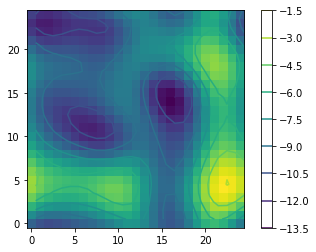

In [93]:
import matplotlib.pyplot as plt
fe = meta.getFreeEnergy()*0.239006
plt.imshow(fe, origin='lower')
plt.contour(fe, origin='lower')
plt.colorbar()


In [94]:
np.save('fe.npy',fe)

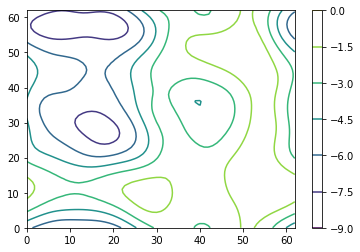

In [80]:
plt.contour(fe)
plt.colorbar()

In [78]:
np.min(fe)-fe[x, y]

-4.669040043009035